In [2]:
import numpy as np
import matplotlib.pylab as plt
import scipy.stats as stats
import pymc3 as pm

import pandas as pd
import seaborn as sns
import arviz as az

# Statistical Rethinking

This notebook is for personal use by me to illustrate and the principles and concepts outlined in the book $\textit{statistical rethinking}$ by Richard McElreath. The book is meant to be done in R, but I prefer python, so I will be converting the relavent and interesting bits of code into python here. This will also be making use of tools for Bayesian statistical inference in python. The package pymc3 will be used for this, and the book $\textit{Bayesian analysis with python}$ by Osvaldo Martin will be used as crutch for learning pymc3 on the fly.

## Chapter 2 

### Grid approximation of the posterior distribution.

In the chaper McElreath outlines the formation formation of a posterior distribution using a grid approximation. Succinctly, this can be thought of as follows: Computers can't actually represent continuous distributions so we discretise our conitnuous functions in order to approximate them such that the computer can actually work with them. This is relevant to Bayesian inference in the following way. We may have some posterior distribution over a parameter, given the data $P(p|D)$. We can compute this function at any particular point $p'$. If we compute the prior of a discrete grid of values, we can obtain a good approximation to what is actually a continuous function. We can easily do this using the tools of numpy to define our grid of values and then perform the computations.

In his book he attempts to approximate the percentage of the Earth's surface covered in water by throwing the globe in the air and asking whether the throwers index finger lands on Water, W, or Land, L. If the p is the fraction of the Earths surface covered in water, then we would like to know p. The looklihood model that this corresponds to is the binomial model

$Pr(W,L|p) = {W+L \choose W} p^W(1-p)^L$

Where W is the number of times water comes up and the L is the number of times land comes up. We place a uniform prior distribution over the range of paramter values for p. This gives

$Pr(p|W,L) \propto Pr(W,L|p)Pr(p)$

where we just need to ensure that normalisation takes place. With the grid method we can compute the approximation to the posterior with the following code. (we piggy back on pre-implemented computations of the likelihood using scipy). We assume we have observed water 6 times and land 3 times in the computation. We will also plot for different numbers of grid points to show how the appriximation improves with the number of grid squares.

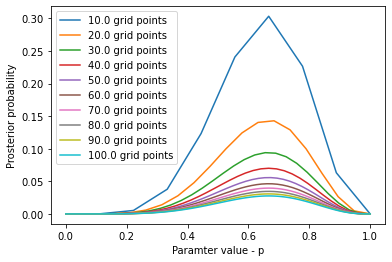

In [41]:
for n in np.linspace(10,100,10):
    #get the grid of parameter values
    p = np.linspace(0,1,int(n))
    #compute the likelihood for each value of p, assuming 6 success and 3 fails
    likelihood = stats.binom.pmf(k =6, n=9,p= p)
    #prior is unif(0,1)
    prior = 1
    #posterior
    post = likelihood*prior
    #normalise the posterior
    post = post/np.sum(post)
    plt.plot(p,post, label = str(n) + " grid points")
    
plt.xlabel("Paramter value - p")
plt.ylabel("Prosterior probability")
plt.legend()
plt.show()

Clearly as there are more and more grid points, the grid approximation becomes a better and better representation of the posterior distribution. The curves appear to have a smaller and smaller area, which would violate the normalisation of property of probability functions. But note here, that in the grid approximation we are assigning probabilities to exact values of p, and as the grid points grow, the more accurately this will represent and continuous pdf. But in the low n limit, far more probability mass is assigned to exact positions, rather than a density over a range of values. So all are valid probabilities, but the low n limit is a poor approximation to the actual continuous posterior distribution.

We can easily reimplement the above code to see the effects of a different prior, eg a step function

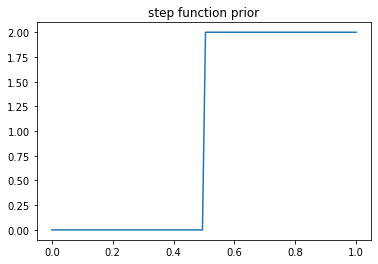

In [26]:
plt.plot(p,np.heaviside(p-0.5, 0.5)*2)
plt.title("step function prior")
plt.show()

In [36]:
for n in np.linspace(10,100,10):
    #get the grid of parameter values
    p = np.linspace(0,1,n)
    #compute the likelihood for each value of p, assuming 6 success and 3 fails
    likelihood = stats.binom.pmf(k =6, n=9,p= p)
    #prior is heaviside step function around 
    prior = np.heaviside(p-0.5, 0.5)*2
    #posterior
    post = likelihood*prior
    #normalise the posterior
    post = post/np.sum(post)
    plt.plot(p,post, label = str(n) + " grid points")
    
plt.xlabel("Paramter value - p")
plt.ylabel("Prosterior probability")
plt.legend()
plt.title("Posterior resulting from step function prior")
plt.show()

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [24]:
np.sum(post)

0.9999999999999999

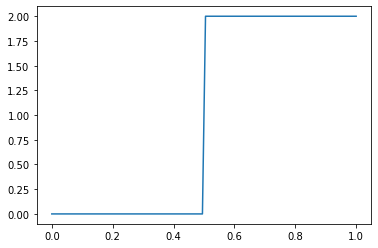

In [23]:
plt.plot(p,np.heaviside(p-0.5, 0.5)*2)

## Laplaces Approximation

In the next part of the chapter, McElreath implements the "quadratic approximation" otherwise referred to as $\textit{Laplace's Method}$. The general thrust of this approach is that many probability distributions look kind of bell curvy, therefore why not approximate it them with The Bell Curve/Normal distribution. In the context of Bayesian inference, one can approximate the prior distribution with the normal approximation. One simply sets the mean of the normal approximation to be at the mode of the distribution you're trying to approximate, and the standard deviation to be 1/curvature at the mode. Without going into (and skipping quite a bit of) detail, this last point makes intuitive sense. If the distribution you're trying to approximate is narrow, it will have a sharp peak with a lot of curvature, but you'll want to approximate it with a narrow gaussian, which corresponds to one with a small standard deviation. The normal approximation can be implemented with pymc3 as follows.

In [19]:
"""Obtain the posterior distribution using pymc3

Then use it to find the maximum and curvature of the distribution and plot this
"""
#define the data for getting 6 W oberved and 3 L
data = np.append(np.ones(6), np.zeros(3))
with pm.Model() as our_first_model:
    #define the prior
    p = pm.Uniform('p')
    #define the likelihood
    y = pm.Bernoulli('y', p=p, observed=data)
    #
    approx_mean = pm.find_MAP()
    approx_std = ((1/pm.find_hessian(approx_mean, vars=[p]))**0.5)[0]

logp = -6.2383, ||grad|| = 1.5: 100%|██████████| 7/7 [00:00<00:00, 1103.72it/s]


In [22]:
approx_mean["p"]

array(0.66666667)

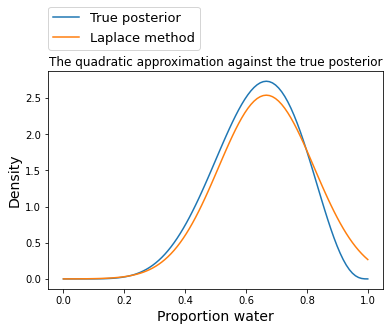

In [26]:
#plot the gaussian approximation to the posterio against the true posterior beta posterior
w, n = 6, 9
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x , w+1, n-w+1),
         label='True posterior')
plt.plot(x, stats.norm.pdf(x, approx_mean["p"], approx_std),
         label='Laplace method')

plt.legend(loc=(0,1.1), fontsize=13)
plt.title("The quadratic approximation against the true posterior")
plt.xlabel('Proportion water', fontsize=14)
plt.ylabel('Density', fontsize=14);

## End of chapter problems

2E1) $\textit{the probability of rain on Monday?}$ can be expressed as 

   (2) $Pr(rain|Monday)$
    
2E2) Pr(Monday|rain) corresponds to?

   (3)  The probability that it is Monday, given that it is raining.
    
2E3) $\textit{the probability that it is Monday, given that it is raining?}$ is equivalent to 

   (1) $Pr(Monday|rain)$
   (3) $\frac{Pr(rain|Monday)Pr(Monday)}{Pr(rain)}$
   
2E4) A fairly philosophical question.

   To say that the probability of something is p=x, is to state our belief about the situation, not to claim that it is objectively the case. So saying the Earth has probability 0.7 that any randomly sample point on its surface will be water is something akin to revealing you believe that around 0.7 of the Earth's surface is covered, but your belief could change in light of new data that you recieve upon further sampling

2M1) Recall the globe tossing model from the chapter. Compute and plot the grid approximate
posterior distribution for each of the following sets of observations. In each case, assume a uniform
prior for p.
(1) W, W, W
(2) W, W, W, L
(3) L, W, W, L, W, W, W

In [33]:
#express the above scenarios as the number of waters in each
W = np.array([3,3,5])
#give the total number of trials
Total = np.array([3,4,7])

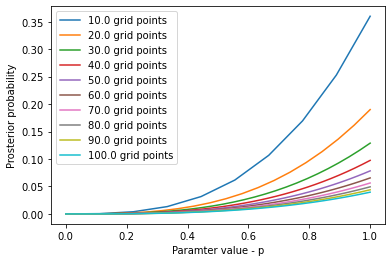

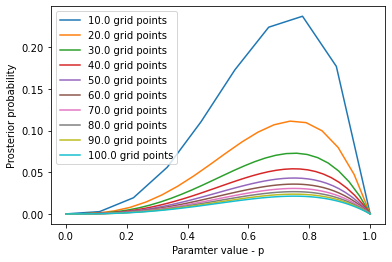

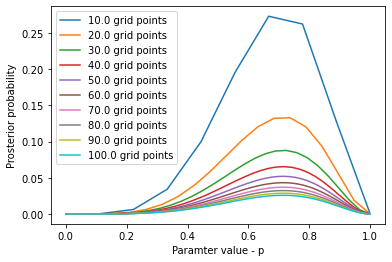

In [44]:
#Get the plots for each scenario, trying different numbers of grid points for each
for i,j in zip(W,Total):
    for n in np.linspace(10,100,10):
        #get the grid of parameter values
        p = np.linspace(0,1,int(n))
        #compute the likelihood for each value of p, assuming 6 success and 3 fails
        likelihood = stats.binom.pmf(k =i, n=j,p= p)
        #prior is unif(0,1)
        prior = 1
        #posterior
        post = likelihood*prior
        #normalise the posterior
        post = post/np.sum(post)
        plt.plot(p,post, label = str(n) + " grid points")

    plt.xlabel("Paramter value - p")
    plt.ylabel("Prosterior probability")
    plt.legend()
    plt.show()

2M2. Now assume a prior for p that is equal to zero when p < 0.5 and is a positive constant when
p ≥ 0.5. Again compute and plot the grid approximate posterior distribution for each of the sets of
observations in the problem just above.

To do this I'll just recycle the code I used above, but I'll modify the prior from being the uniform distribution to become the Heaviside function $\theta(x-0.5)$

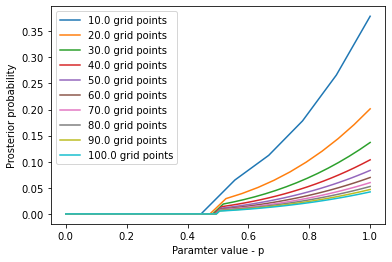

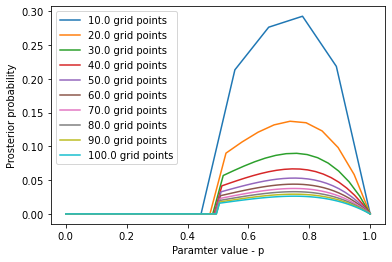

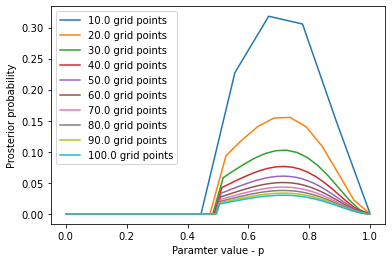

In [45]:
#Get the plots for each scenario, trying different numbers of grid points for each
for i,j in zip(W,Total):
    for n in np.linspace(10,100,10):
        #get the grid of parameter values
        p = np.linspace(0,1,int(n))
        #compute the likelihood for each value of p, assuming 6 success and 3 fails
        likelihood = stats.binom.pmf(k =i, n=j,p= p)
        #prior is step function
        prior = np.heaviside(p-0.5, 0.5)*2
        #posterior
        post = likelihood*prior
        #normalise the posterior
        post = post/np.sum(post)
        plt.plot(p,post, label = str(n) + " grid points")

    plt.xlabel("Paramter value - p")
    plt.ylabel("Prosterior probability")
    plt.legend()
    plt.show()

2M3. Suppose there are two globes, one for Earth and one for Mars. The Earth globe is 70% covered
in water. The Mars globe is 100% land. Further suppose that one of these globes—you don’t know
which—was tossed in the air and produced a “land” observation. Assume that each globe was equally
likely to be tossed. Show that the posterior probability that the globe was the Earth, conditional on
seeing “land” (Pr(Earth|land)), is 0.23.

This is a straight forward Bayesian inference question along the following lines

$Pr(E|L) = \frac{Pr(L|E)Pr(E)}{Pr(L)} = \frac{Pr(L|E)Pr(E)}{Pr(L|E)Pr(E) + Pr(L|M)Pr(M)} = \frac{Pr(L|E)}{Pr(L|E) + Pr(L|M)} = \frac{0.3}{1+0.3} = 0.23...$

where I have used the fact that the Pr(E)=Pr(M) and Pr(L|E) = 1 - Pr(W|E) = 1 - 0.7 = 0.3

2M4. Suppose you have a deck with only three cards. Each card has two sides, and each side is either
black or white. One card has two black sides. The second card has one black and one white side. The
third card has two white sides. Now suppose all three cards are placed in a bag and shuffled. Someone
reaches into the bag and pulls out a card and places it flat on a table. A black side is shown facing up,
but you don’t know the color of the side facing down. Show that the probability that the other side is
also black is 2/3. Use the counting method (Section 2 of the chapter) to approach this problem. This
means counting up the ways that each card could produce the observed data (a black side facing up
on the table).

Another rudimentary application of Bayes' theorem. Call DB:= you picked a double black card, B:= Observed a black face, then

$Pr(DB|B) = \frac{Pr(B|DB)Pr(DB)}{Pr(B)} = \frac{(1)(1/3)}{1/2} = 2/3$

Pr(B) = 1/2 as half that you might pick are indeed black

Pr(DB|B) = 1 as if you pick the double black card, you have to see a black face

Pr(DB) = 1/3 as there are 3 possible cards you might choose

2M5. Now suppose there are four cards: B/B, B/W, W/W, and another B/B. Again suppose a card is
drawn from the bag and a black side appears face up. Again calculate the probability that the other
side is black.

The probability that the other side is black is the same as the probability that you picked a double black card, given that you saw a black face. We can reapply Bayes' theorem with updated values

$Pr(DB|B) = \frac{Pr(B|DB)Pr(DB)}{Pr(B)} = \frac{(1)(1/2)}{5/8} = 4/5$

as 4/5 of the faces are black and you have a 50-50 chance of picking a double black card in this set-up

2M6. Imagine that black ink is heavy, and so cards with black sides are heavier than cards with white
sides. As a result, it’s less likely that a card with black sides is pulled from the bag. So again assume
there are three cards: B/B, B/W, and W/W. After experimenting a number of times, you conclude that
for every way to pull the B/B card from the bag, there are 2 ways to pull the B/W card and 3 ways to
pull the W/W card. Again suppose that a card is pulled and a black side appears face up. Show that
the probability the other side is black is now 0.5. Use the counting method, as before.


To make this clearer, this is equivalent to setting a new prior distribution on the set of cards that you have. They are as follows. 

$Pr(B/B) = \frac{1}{1+2+3}$

$Pr(B/W) = \frac{2}{1+2+3}$

$Pr(W/W) = \frac{3}{1+2+3}$

Then we can see that this implies the following

$Pr(B) = Pr(B|B/B)Pr(B/B) + Pr(B|B/W)Pr(B/W) + Pr(B|W/W)Pr(W/W) = 1 \times 1/6 + 1/2 \times 2/6 + 0 \times1/2 = 1/3$

Giving the final result to be

$Pr(DB|B) = \frac{Pr(B|DB)Pr(DB)}{Pr(B)} =  \frac{1 \times 1/6}{1/3} = 1/2$

QED

2M7. Assume again the original card problem, with a single card showing a black side face up. Before
looking at the other side, we draw another card from the bag and lay it face up on the table. The face
that is shown on the new card is white. Show that the probability that the first card, the one showing
a black side, has black on its other side is now 0.75. Use the counting method, if you can. Hint: Treat
this like the sequence of globe tosses, counting all the ways to see each observation, for each possible
first card.

We can solve this as follows. Let B/B be the event that the first card picked was double black and B/W be the event that the first card picked was the Black and white mixed card. Now let $B_1$ and $W_2$ be the observations that the face observed on the first card was black and the face observed on the second was white. We can apply Bayes' theorem in the usual manner

$Pr(B/B) = \frac{Pr(B_1,W_2|B/B)Pr(B/B)}{Pr(B_1,W_2)}$

Using the law total probability and the properties of conditional probabilities we can find the denominator with the following

$Pr(B_1,W_2) = Pr(B_1,W_2|B/B)Pr(B/B) + Pr(B_1,W_2|B/W)Pr(B/W)$

(We can ignore conditioning on the W/W event, as it's impossible to observe a black face if this was the first card you picked)

$ = Pr(W_2|B_1,B/B)Pr(B_1|B/B)Pr(B/B) + Pr(W_2|B_1,B/W)Pr(B_1|B/W)Pr(B/W)$

$ = 3/4 \times 1 \times 1/3 + 1/2 \times 1/2 \times 1/3$

$ Pr(B_1,W_2) = 1/3$

Plugging in, we get 

$\frac{Pr(B_1,W_2|B/B)Pr(B/B)}{Pr(B_1,W_2)} = \frac{3/4 \times 1/3}{1/3} = 3/4$

QED

2H1. Suppose there are two species of panda bear. Both are equally common in the wild and live
in the same places. They look exactly alike and eat the same food, and there is yet no genetic assay
capable of telling them apart. They differ however in their family sizes. Species A gives birth to twins
10% of the time, otherwise birthing a single infant. Species B births twins 20% of the time, otherwise
birthing singleton infants. Assume these numbers are known with certainty, from many years of field
research.
Now suppose you are managing a captive panda breeding program. You have a new female panda
of unknown species, and she has just given birth to twins. What is the probability that her next birth
will also be twins?

As we have asolutely no reason to prefer one species over the other, we should choose to use a uniform prior over the data.
Let $T_1$ denote the first offspring were twins. Let A and B denote the panda being from species A and B respectively. Using this in Bayes' theorem we get

$Pr(A|T_1) = \frac{Pr(T_1|A)Pr(A)}{Pr(T_1)} = \frac{Pr(T_1|A)Pr(A)}{Pr(T_1|B)Pr(B) + Pr(T_1|A)Pr(A)} = \frac{Pr(T_1|A)}{Pr(T_1|B) + Pr(T_1|A)} = \frac{0.1}{0.2+0.1} = 1/3$

Which implies 

$Pr(B|T_1) = 1 - Pr(A|T_1) = 2/3$

This all fits in nicely with McElreath's notion of the proportion of the forking garden paths which produce the data given by a hypothesis is the appropriate posterior probability. Why? Because in this case, if 10% of species A produces twins and 20% of species B produce twins, and both species are in all other ways indistringuishable, then it makes intuitive sense that 1/3 and 2/3 of all twins observations are attributable to species A and B respectively. This fits our intuitions of assigning probability in accordance to the frequency of the hypotheses producing the data.

To predict the next set of offspring this panda will produce, we compute the probability of producing twins in each species, weighted by the posterior probability of being from each species.

$Pr(T_2|T_1) = Pr(T_2|A,T_1)Pr(A|T_1) + Pr(T_2|B,T_1)Pr(B|T_1) = 0.1 \times 1/3 + 0.2 \times 2/3 = 1/6$

As we can see, the evidence from the twins in the first generation has increased our likelihood of observing twins in the second generation when we incorporate the evidivence appropriately. Before we knew about the first generation, we would have said the probability of twins was about $0.1 \times 1/2 + 0.2 \times 1/2 = 3/20$ As we can see, the evidence has increased the probability we assigned to the next obserbation being twins.

2H3. Continuing on from the previous problem, suppose the same panda mother has a second birth
and that it is not twins, but a singleton infant. Compute the posterior probability that this panda is
species A

We can just plug all the data into Bayes' theorem in one go:

$Pr(A|S_2,T_1) = \frac{Pr(S_2,T_1|A)Pr(A)}{Pr(S_2,T_1|A)Pr(A) + Pr(S_2,T_1|B)Pr(B)} = \frac{Pr(S_2,T_1|A)}{Pr(S_2,T_1|A) + Pr(S_2,T_1|B)} = \frac{0.1 \times 0.9}{0.1 \times 0.9 + 0.2 \times 0.8} = 0.36$

This implies that the species B is more informed. This might seem like quite a large skew to the posterior probabilites given the data. However, any twins observation is much more overwhelming evidence for species B than any singles observation is evidence for species A. Hence the fact that half our observations so far we twins is still strong evidence that this panda was from species B.

2H4. A common boast of Bayesian statisticians is that Bayesian inference makes it easy to use all of
the data, even if the data are of different types.
So suppose now that a veterinarian comes along who has a new genetic test that she claims can
identify the species of our mother panda. But the test, like all tests, is imperfect. This is the information you have about the test:
• The probability it correctly identifies a species A panda is 0.8.
• The probability it correctly identifies a species B panda is 0.65.
The vet administers the test to your panda and tells you that the test is positive for species A. First
ignore your previous information from the births and compute the posterior probability that your
panda is species A. Then redo your calculation, now using the birth data as well.

Given only the test data we can write $Test_A$ to indicate the test results said species A. Deploying Bayes' theorem we find that $Pr(A|Test_A) = \frac{Pr(Test_A|A)Pr(A)}{Pr(Test_A)} = \frac{Pr(Test_A|A)Pr(A)}{Pr(Test_A|A)Pr(A) + Pr(Test_A|B)Pr(B)} $

Using a standard property of conidtional probabilities $Pr(Test_A|B) = 1 - Pr(Test_B|B) = 1 - 0.65 = 0.35$. This is the probaility that the test was wrong given that the species was actually B. As we have a uniform prior, we now find that:

$ = \frac{Pr(Test_A|A)Pr(A)}{Pr(Test_A|A)Pr(A) + Pr(Test_A|B)Pr(B)} =  \frac{Pr(Test_A|A)}{Pr(Test_A|A) + Pr(Test_A|B)} = \frac{0.8}{0.8+ 0.35} = 0.72$ 

That is, testing positive for A would constitute reasonable evidence for the bear being of species A.

If we incorporate all of the data into this Bayesian update, we can do it all in one go. We need the likelihood of observing the data, which I'll denote short hand by $D = Test_A,T_1,S_2$. The likelihood of each of these data points is independent from one another so we find that

$Pr(A|D) = \frac{Pr(D|A)}{Pr(D|A) + Pr(D|B)} = \frac{0.8 \times 0.1 \times 0.9}{0.8 \times 0.1 \times 0.9 + 0.35 \times 0.2 \times 0.8} = 0.5625$

When all of the data is incorporated, then we see that it's much nearer to 50-50. This is because the twin data points away from species A, whilst the Test data points in favour of species A, counteracting to a large degree, so the combined data is more ambigious.

The way I computed the bayesian update in the step above was to compute the likelihood for the data all in one go. However, I have the posterior distribution given the birth data. I should be able to use the posterior from the birthdata as my prior for the test data and get the same result as combining everything in one go. Lets check to see that this is write:

Our prior with the birth data would be Pr(A) = 0.36, Pr(B) = 0.64 from my solution to 2H3. Setting this as the prior in our Bayesian update for the test data gives that $Pr(A|Test_A) = \frac{Pr(Test_A|A)Pr(A)}{Pr(Test_A|A)Pr(A) + Pr(Test_A|B)Pr(B)} = \frac{0.8 \times 0.36}{0.8 \times 0.36 + 0.35 \times 0.64} = 0.5625$

Nicely, everything is in agreement. We can perform our Bayesian updates in one step or by using our earlier posteriors as our new priors. We can show these are mathematically equivalent. Let's assume we used the earlier posterior as our new prior. Then we could write $A' = A|S_2,T_1$. Then using our posterior as prior, we write the final update step as 

$Pr(A'|Test_A) = \frac{Pr(Test_A|A')Pr(A')}{Pr(Test_A)} $

which is equivalent to

$Pr(A|S_2,T_1,Test_A) = \frac{Pr(Test_A \cap A')}{Pr(Test_A)} =  \frac{Pr(Test_A \cap A,S_2,T_1)}{Pr(Test_A)} $

## Chapter 3

### End of chapter problems

All of this chapter depends on the posterior distribution for the globe spinning example. I will implement pymc3 to do most of the leg work for me. As before, set the prior to be the uniform and the likelihood to be the binomial. The data given in the book is the set of outcomes W L W W W L W L W, which I'll give a binary representation in the same order.

Pymc3 nicey allows you to state the prior and the likelihood function of the data. You can use its pm.sample function in order to obtain a random sample from the posterior distribution. This is done using MCMC techniques, but they aren't introduced until later in Statistical rethinking. You can run "chains" of the sampling procedure to sanity check the MCMC methods that took place. The samples from the posterior distribution are also returned and we can perform inference on the posterior according to this.

In [88]:
data = np.array([1,0,1,1,1,0,1,0,1])

logp = -6.2383, ||grad|| = 1.5: 100%|██████████| 7/7 [00:00<00:00, 984.55it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:04<00:00, 1283.60draws/s]
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/aidan

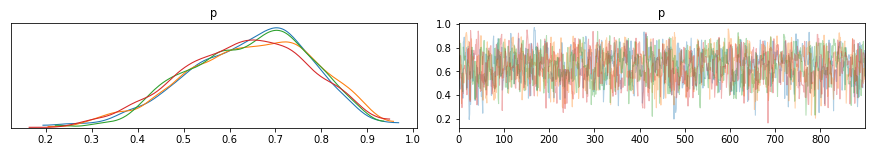

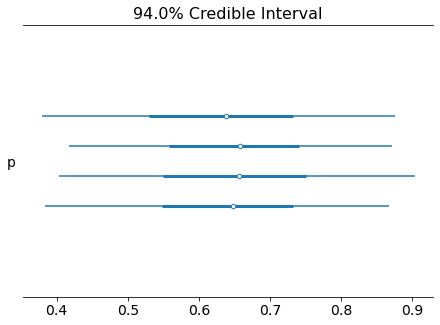

In [91]:
with pm.Model() as our_first_model:
    p = pm.Uniform('p') #set the prior
    y = pm.Bernoulli('y', p=p, observed=data) #set the posterior
    start = pm.find_MAP() #set the max posterior as start point
    trace = pm.sample(1000,  start=start, chains =4) #get 1000 random_samples
    burnin = 100
    chain = trace[burnin:]
    pm.traceplot(chain, lines={'theta':0.6})
    pm.forestplot(trace, varnames=['p'])

Text(0.5, 0, 'Parameter Value')

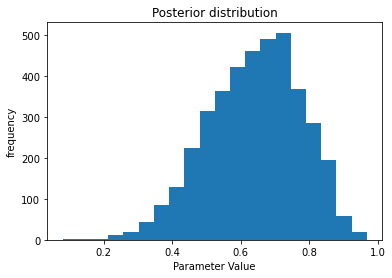

In [92]:
#plot the posterior
plt.hist(trace["p"], bins = 20)
plt.title("Posterior distribution")
plt.ylabel("frequency")
plt.xlabel("Parameter Value")

3E1. How much posterior probability lies below p = 0.2?

In [97]:
samples = trace["p"]
print(str(np.sum(samples < 0.2)/samples.size) + " of the posterior lies below 0.2" )

0.001 of the posterior lies below 0.2


3E2. How much posterior probability lies above p = 0.8?

In [98]:
print(str(np.sum(samples > 0.8)/samples.size) + " of the posterior lies above 0.8" )

0.11975 of the posterior lies above 0.8


3E3. How much posterior probability lies between p = 0.2 and p = 0.8?

There are two ways to compute this. You can either do $1 - P_{<0.2} - P_{>0.8}$ or you can re_compute the interval. These are implemented in the respective order.

In [107]:
print(str(1 -np.sum(samples > 0.8)/samples.size -np.sum(samples < 0.2)/samples.size) + " of the posterior lies between 0.2 & 0.8" )

0.87925 of the posterior lies between 0.2 & 0.8


In [102]:
print(str(np.sum((samples < 0.8) &(samples > 0.2))/samples.size) + " of the posterior lies above 0.8" )

0.87925 of the posterior lies above 0.8


Thankfully, they are both in agreement.

3E4. 20% of the posterior probability lies below which value of p?

There are a bunch of ways to implement this in python. In the past, I have foolishly taken great pains to order arrays of data explicitly to produce quantiles. Here, there is the neat numpy quantile function which let's us do this immediately.

In [109]:
print("The 20% quantile of the posterior is " + str(np.quantile(samples,0.2)))

The 20% quantile of the posterior is 0.5191560976004063


By eyeballing the histogram of the samples this seems sensible.

3E5. 20% of the posterior probability lies above which value of p?

This is just the 80% quantile

In [110]:
print("20% of the probability mass lies above " + str(np.quantile(samples,0.8)))

20% of the probability mass lies above 0.7593594225596587


3E6. Which values of p contain the narrowest interval equal to 66% of the posterior probability?

pymc3 has a function to help us compute the highest density posterior interval. The function is called hpd, for highest posterior density. This interval is also the narrowest.

In [117]:
hpd_interval= pm.stats.hpd(samples, credible_interval=0.66)
print(hpd_interval)

[0.50230458 0.77072979]


Sanity checking this, it's seen that the interval does in fact contain around 66% of the mass

In [116]:
print(str(1 -np.sum(samples > hpd_interval[1])/samples.size -np.sum(samples < hpd_interval[0])/samples.size))

0.66025


3E7. Which values of p contain 66% of the posterior probability, assuming equal posterior probability both below and above the interval?

I haven't found a neat function which just finds the central interval of any data. But using the quantile function we can find the lower and upper 1/6 quantiles, which are equivalent to the central 66% quantile

In [119]:
np.quantile(samples,(1/6,5/6))

array([0.50364282, 0.77581499])

This is very similar to the 66% hpd interval found earlier. As this posterior is relatively bell curved, and has a vague amount of symmetry to it, this similarity between these two central intervals isn't too surprising.

3M1. Suppose the globe tossing data had turned out to be 8 water in 15 tosses. Construct the posterior distribution, using grid approximation. Use the same flat prior as before

I'm going to recycle the code from earlier

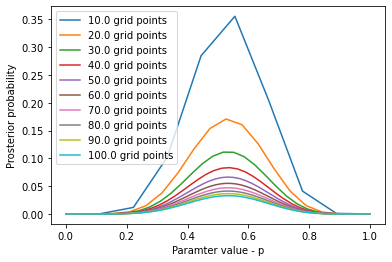

In [174]:
w, n = 8, 15
for points in np.linspace(10,100,10):
    #get the grid of parameter values
    p = np.linspace(0,1,int(points))
    #compute the likelihood for each value of p, assuming 6 success and 3 fails
    likelihood = stats.binom.pmf(k =w, n=n,p= p)
    #prior is unif(0,1)
    prior = 1
    #posterior
    post = likelihood*prior
    #normalise the posterior
    post = post/np.sum(post)
    plt.plot(p,post, label = str(points) + " grid points")

plt.xlabel("Paramter value - p")
plt.ylabel("Prosterior probability")
plt.legend()
plt.show()

This produces a much more symmetrical distribution of the data for us to work with.

3M2. Draw 10,000 samples from the grid approximation from above. Then use the samples to calculate the 90% HPDI for p

Let's use the distribution found for 100 grid points as there seems to be reasonable convergence in the distributions at this point so far. The variable post will be set to the posterior distribution for 100 grib points as this was the last place in the for loop ran above so we can just sample from it.

In [175]:
#sample from the grid points in accordance with the weights of the probabilities assigned by the posterior
samples = np.random.choice(p,size=10000,replace =True, p=post)

In [176]:
#obtain the HPDI for the sample from the grid posterior
pm.stats.hpd(samples)

array([0.32323232, 0.74747475])

3M3. Construct a posterior predictive check for this model and data. This means simulate the distribution of samples, averaging over the posterior uncertainty in p. What is the probability of observing
8 water in 15 tosses?

So we have samples from our posterior distribution. Each of these samples represents a parameter value, and each parameter value should appear in the sample in accordance with the likelihood accorded it by the posterior. For each samples parameter value, we can produce data, as if it were produced from a binomial distribution with that parameter value. This can be very easily implemented in numpy as follows

In [177]:
#construct the posterior predictive distribution
ppd = np.random.binomial(n = 15, p = samples)

In [178]:
ppd.shape

(10000,)

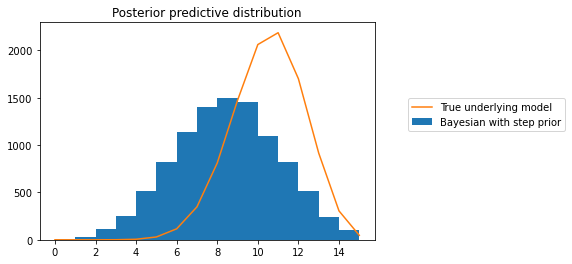

In [179]:
plt.hist(ppd, bins =15, label="Bayesian with step prior")
plt.plot(np.linspace(0,15,16),10000*stats.binom.pmf(np.linspace(0,15,16), n= 15, p =0.7),label="True underlying model")
plt.title("Posterior predictive distribution")
plt.legend(loc=(1.1,0.5))

This looks fairly consistent with the data, and the posterior would gladly predict the data that we actually saw.

3M4. Using the posterior distribution constructed from the new (8/15) data, now calculate the probability of observing 6 water in 9 tosses.

I take this to mean, given that we just observed 8/15 in our first data set, what probability do we assign to see 6/15 on another trial of 15 tosses of the globe

In [180]:
print("probability of 6 waters on the next trial " + str(np.sum(ppd == 6)/ppd.shape))

probability of 6 waters on the next trial [0.1134]


3M5. Start over at 3M1, but now use a prior that is zero below p = 0.5 and a constant above p = 0.5.
This corresponds to prior information that a majority of the Earth’s surface is water. Repeat each
problem above and compare the inferences. What difference does the better prior make? If it helps,
compare inferences (using both priors) to the true value p = 0.7

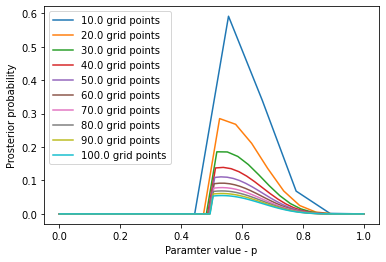

In [188]:
w, n = 8, 15
for points in np.linspace(10,100,10):
    #get the grid of parameter values
    p = np.linspace(0,1,int(points))
    #compute the likelihood for each value of p, assuming 6 success and 3 fails
    likelihood = stats.binom.pmf(k =w, n=n,p= p)
    #prior is step function
    prior = np.heaviside(p-0.5, 0.5)*2
    #posterior
    post = likelihood*prior
    #normalise the posterior
    post = post/np.sum(post)
    plt.plot(p,post, label = str(points) + " grid points")

plt.xlabel("Paramter value - p")
plt.ylabel("Prosterior probability")
plt.legend()
plt.show()

The obvious steps in the posterior induced by the prior

3M2. Draw 10,000 samples from the grid approximation from above. Then use the samples to calculate the 90% HPDI for p

Let's use the distribution found for 100 grid points as there seems to be reasonable convergence in the distributions at this point so far. The variable post will be set to the posterior distribution for 100 grib points as this was the last place in the for loop ran above so we can just sample from it.

In [189]:
#sample from the grid points in accordance with the weights of the probabilities assigned by the posterior
samples = np.random.choice(p,size=10000,replace =True, p=post)

In [190]:
#obtain the HPDI for the sample from the grid posterior
pm.stats.hpd(samples)

array([0.50505051, 0.73737374])

3M3. Construct a posterior predictive check for this model and data. This means simulate the distribution of samples, averaging over the posterior uncertainty in p. What is the probability of observing
8 water in 15 tosses?

So we have samples from our posterior distribution. Each of these samples represents a parameter value, and each parameter value should appear in the sample in accordance with the likelihood accorded it by the posterior. For each samples parameter value, we can produce data, as if it were produced from a binomial distribution with that parameter value. This can be very easily implemented in numpy as follows

In [191]:
#construct the posterior predictive distribution
ppd = np.random.binomial(n = 15, p = samples)

In [192]:
ppd.shape

(10000,)

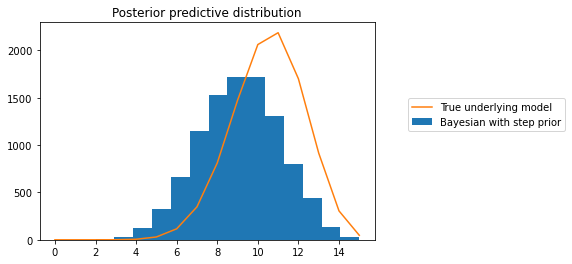

In [194]:
plt.hist(ppd, bins =14, label="Bayesian with step prior")
plt.plot(np.linspace(0,15,16),10000*stats.binom.pmf(np.linspace(0,15,16), n= 15, p =0.7),label="True underlying model")
plt.title("Posterior predictive distribution")
plt.legend(loc=(1.1,0.5))

It can be seen that the posterior predictive distribution and the final confidence intervals are much much narrower than was previously the case for the data, and centre closer to the true value of 0.7. Additionally, the predictions of the future data were more inline with what woukd be expected for the true parameter value of 0.7. Using a more reasonable prior than the uniform prior can really improve predictive power in the future. The point is you should incorporate any domanin knowledge you have into the prior where possible.

3M6. Suppose you want to estimate the Earth’s proportion of water very precisely. Specifically, you
want the 99% percentile interval of the posterior distribution of p to be only 0.05 wide. This means
the distance between the upper and lower bound of the interval should be 0.05. How many times will
you have to toss the globe to do this?

This depends on a bunch of things. I don't really know if there's something to do with runnin

# Do the above sometime in a way that's sensible

Hard. The Hard problems here all use the data below. These data indicate the gender (male=1, female=0) of officially reported first and second born children in 100 two-child families.


In [3]:
birth1 = np.array([1,0,0,0,1,1,0,1,0,1,0,0,1,1,0,1,1,0,0,0,1,0,0,0,1,0,
0,0,0,1,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,
1,1,0,1,0,0,1,0,0,0,1,0,0,1,1,1,1,0,1,0,1,1,1,1,1,0,0,1,0,1,1,0,
1,0,1,1,1,0,1,1,1,1])
birth2 = np.array([0,1,0,1,0,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0,0,1,1,1,0,
1,1,1,0,1,1,1,0,1,0,0,1,1,1,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,
1,1,1,0,1,1,0,1,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,1,
0,0,0,1,1,1,0,0,0,0])

In [4]:
birth1.shape, birth2.shape

((100,), (100,))

3H1. Using grid approximation, compute the posterior distribution for the probability of a birth
being a boy. Assume a uniform prior probability. Which parameter value maximizes the posterior
probability?

I'll do this with 1,000 grid points to improve the precision of the posterior

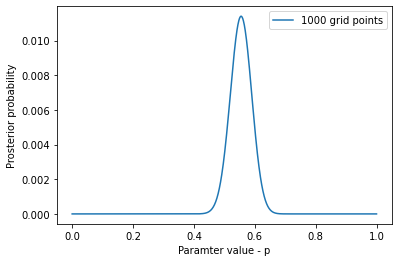

In [7]:
#get the number of boys
num_boys = np.sum(birth1) + np.sum(birth2)
#get a 1,000 grid of parameter values
p = np.linspace(0,1,1000)
#compute the likelihood for each value of p, assuming num_boy successes and 200 trials
likelihood = stats.binom.pmf(k =num_boys, n=200,p= p)
#prior is unif(0,1)
prior = 1
#posterior
post = likelihood*prior
#normalise the posterior
post = post/np.sum(post)
plt.plot(p,post, label = str(1000) + " grid points")

plt.xlabel("Paramter value - p")
plt.ylabel("Prosterior probability")
plt.legend()
plt.show()

In [21]:
#find value of numpy array with max value
p[np.argmax(post)]

0.5545545545545546

3H2. Using the sample function, draw 10,000 random parameter values from the posterior distribution you calculated above. Use these samples to estimate the 50%, 89%, and 97% highest posterior
density intervals.

In [15]:
#sample from the posterior
post_sample = np.random.choice(p,replace = True,size =10000,p=post)

In [19]:
#use pymc to find the hpdi
print("50% HPDI " +str(pm.stats.hpd(post_sample, 0.5)))
print("89% HPDI " +str(pm.stats.hpd(post_sample, 0.89)))
print("97% HPDI " +str(pm.stats.hpd(post_sample, 0.97)))

50% HPDI [0.53353353 0.57857858]
89% HPDI [0.4984985  0.60760761]
97% HPDI [0.47747748 0.62562563]


As there's a lot of samples in this data set, a considerable amount of probability mass has been concentrated onto narrow range. Hence the HPDIs don't exhibit huge changes with change in the amount of probability mass included within the interval. Nicely, within the 97% HPDI is the value of p=0.5, which would mean equal probability of having a boy or a girl which matches the conventional wisdom.

3H3. Use rbinom to simulate 10,000 replicates of 200 births. You should end up with 10,000 numbers, each one a count of boys out of 200 births. Compare the distribution of predicted numbers
of boys to the actual count in the data (111 boys out of 200 births). There are many good ways to
visualize the simulations, but the dens command (part of the rethinking package) is probably the
easiest way in this case. Does it look like the model fits the data well? That is, does the distribution
of predictions include the actual observation as a central, likely outcome?

I take this rather poorly phrased question to mean, using the 10,000 samples from the posterior distribution that you just obtained, produce a random sample from the posterior predictive distributiom of future births.

In [23]:
ppd = np.random.binomial(n =200, p = post_sample)

Text(0, 0.5, 'Frequency')

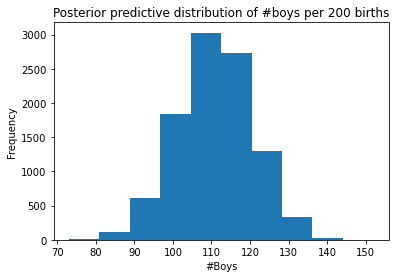

In [25]:
plt.hist(ppd)
plt.title("Posterior predictive distribution of #boys per 200 births")
plt.xlabel("#Boys")
plt.ylabel("Frequency")

Given that there were 111 boys given birth to in the actual data, the posterior predictive distribution from the model appears to be consistent with observations.

3H4. Now compare 10,000 counts of boys from 100 simulated first borns only to the number of boys
in the first births, birth1. How does the model look in this light?

I take this to mean, using the posterior distribution, from the full data set, what is your posterior predictive distribution for the trials of 100 births, and how does this compare to the 100 births actually observed in the birth1 data.

In [50]:
#get the ppd for 100 birth trials
ppd100 = np.random.binomial(n =100, p = post_sample)

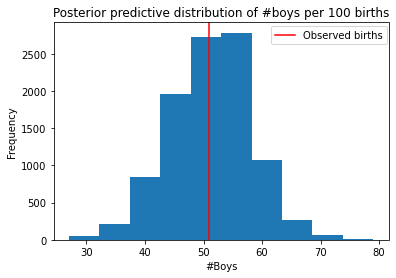

In [65]:
plt.hist(ppd100)
plt.title("Posterior predictive distribution of #boys per 100 births")
plt.xlabel("#Boys")
plt.ylabel("Frequency")
plt.axvline(np.sum(birth1), c="r", label ="Observed births")
plt.legend(loc=(0.65,0.9))
plt.show()

As we can see, the observed number of male births in the first births group is consistent with the models own predictions as we would like it to be.

I would say that the model looks perfectly consistent using only this training data. 

3H5. The model assumes that sex of first and second births are independent. To check this assumption, focus now on second births that followed female first borns. Compare 10,000 simulated counts
of boys to only those second births that followed girls. To do this correctly, you need to count the
number of first borns who were girls and simulate that many births, 10,000 times. Compare the
counts of boys in your simulations to the actual observed count of boys following girls. How does the
model look in this light? Any guesses what is going on in these data?

In [44]:
#obtain the number of boys who's births followed girls
print(str(birth2[birth1 == 0].sum()) + " male births follow female births")
print(str(birth2[birth1 == 0].shape[0]) + " Total female first births")

39 male births follow female births
49 Total female first births


In [61]:
#ppd for male after female (mAf) births
ppd_mAf = np.random.binomial(n = 49, p = post_sample)


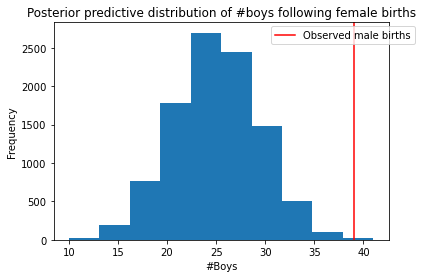

In [64]:
plt.hist(ppd_mAf)
plt.title("Posterior predictive distribution of #boys following female births")
plt.xlabel("#Boys")
plt.ylabel("Frequency")
plt.axvline(birth2[birth1 == 0].sum(), c="r", label ="Observed male births")
plt.legend(loc=(0.65,0.9))
plt.show()

The male births following female births as seen in the data is very different from what the model would have predicted. The likely culprit here is that the model said male and female births were independent. However, this data would imply that once a female has been born you become much more likely to have a male second child, which is in direct conflict with the indpendence assumption baked into the model. Based on this, one could construct a model of that data which attempts to take the anti-correlated birth gender into account.

## Chapter 4

### 4.1 The prevelance of the normal distribution

As noted in the opening sequence of the chapter, the normal distribution is fairly ubiquitous both in nature and our (potentially incorrect) models of nature. There a several processes which can give rise to the normal distribution, and I just want to take a small detour here to reimlpement some of those here.

### Normality by sum of i.i.ds 

Sums of independent identially distibuted (iid) random variables will often have a normal distribution as long as the constituents of the sum have finite mean and variance. This is the essence of what the central limit theorem (or at least the standard introductory version of it) is all about. As an example of this behaviour, below, I take a sample of 50 iid random exponentials and sum them together. I then repeat this trail 1,000 times and plot the histogram of sums. This looks very normal

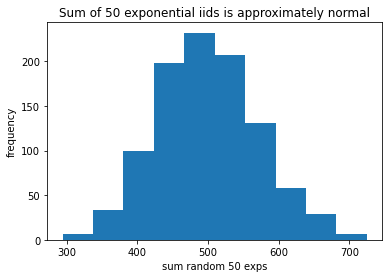

In [3]:
#1000 trials of 50 iid random exponentials being summed together.
trials = np.random.exponential(scale = 10, size = (1000,50))#random exps with scale param 10
#sum each of the 50 values in each trial
sums = np.sum(trials, axis =1)

plt.hist(sums)
plt.title("Sum of 50 exponential iids is approximately normal")
plt.xlabel("sum random 50 exps")
plt.ylabel("frequency")
plt.show()

### Normality by products of small changes

McElreath points out that the the product of numbers with small changes will also be approximately normal. This is because multiplying numbers with small variations is close to addition. Eg $ 1.1 \times 1.05 = (1+0.1)(1+0.05) \approx 1 + 0.1 + 0.05$ ignoring very small terms like $0.1 \times 0.05$ as they're negligble to the outcome. So for instance is we have A and B both ~ Unif(0.9,1.1), then this is equivalent to $A = 1 + a$ and $B = 1 + b$ where a and b ~ Unif(-0.1,0.1). Following the logic through $A \times B = (1 + a) (1 + b) \approx 1 + a + b $, again ignoring the very small $ a \times b$ terms. Thus $A \times B$ is roughly the sum of three random variables for these small numbers near 1. As an example of this, I will take the product of 20 Unif(0.95,1.05) random variables. The code below does this 1,000 times and plots the resulting histogram.

In [13]:
#sample the unif 20 times for 1,000 trials
trials = np.random.uniform(0.95,1.05,size=(1000,20))
prods = np.product(trials, axis = 1)


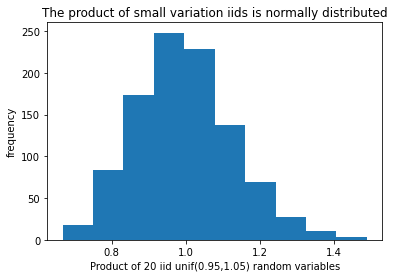

In [14]:
plt.hist(prods)
plt.title("The product of small variation iids is normally distributed")
plt.xlabel("Product of 20 iid unif(0.95,1.05) random variables")
plt.ylabel("frequency")
plt.show()

### Normality by logarithm of a product of large changes

It is generally well known that the product of random variables tends to be log normally distributed. When the random variables exhibit large variations, the summation approximation mentioned above breaks down. However, in general it is the case that if Z is a product of iids, $X_i$, $Z = \prod_i X_i$, then $log(Z) = log(\prod_i X_i) = \sum log(X_i) = \sum Y_i$, where $Y_i = log(X_i)$. Thus it can be seen that log(Z) is a sum of iids, which will be approximately normally distributed as has been shown earlier. Thus goes the dictum that products of random variables are "log normally distribued" as their logarithms will product a normal distribution. I'll show an example below by taking 50 iids from Unif(0,50), taking their product and repeating this trail 1,000 times and plotting the histogram of the resulting data. 

In [15]:
#50 random Unif(0,50) for 1,000 trials
trials = np.random.uniform(0,50,size=(1000,50))
#take the product
prods = np.product(trials, axis =1)
#take the logarithms
log_prods = np.log(prods)

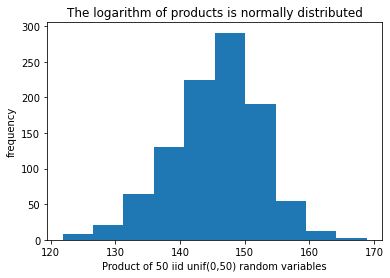

In [17]:
plt.hist(log_prods)
plt.title("The logarithm of products is normally distributed")
plt.xlabel("Product of 50 iid unif(0,50) random variables")
plt.ylabel("frequency")
plt.show()

Before proceeding to the end of chapter problems for this chapter, there is a lot of material worth recapitulating using python. I will follow the sequential order of the chapter.

### Gaussian models of height 4.3

#### Obtaining a prior predictive distribution

In [2]:
#load in the data
howell1 = pd.read_csv("data/Howell1.csv", delimiter=";")

In [17]:
howell1.head(5)

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


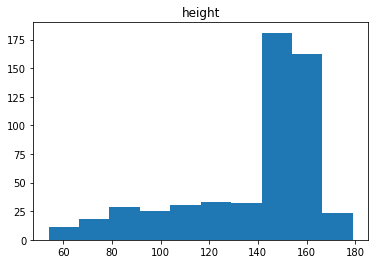

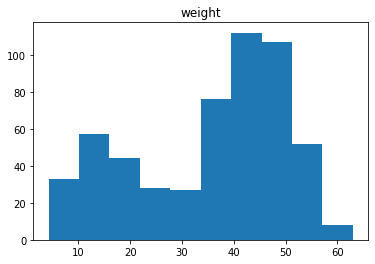

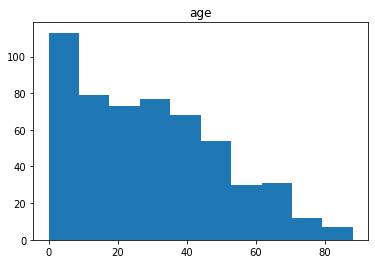

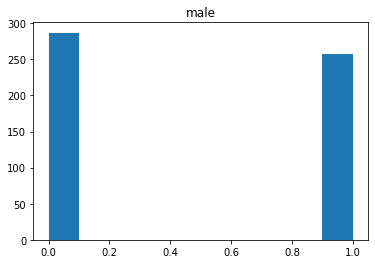

In [16]:
for col in howell1.columns.values:
    plt.hist(howell1[col])
    plt.title(col)
    plt.show()

In [19]:
#get the adult only heights
ad_height = howell1[howell1.age >= 18].height

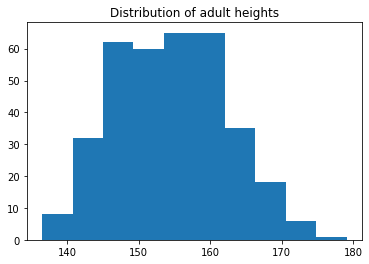

In [21]:
plt.hist(ad_height)
plt.title("Distribution of adult heights")
plt.show()

In the first model the McElreath discusses, the height of adults in the population can be thought of as being normally distributed. $h_i$ ~ $N(\mu,\sigma^2)$, where all $h_i$ are independent of one another. This is a reasonable but not totally perfect model of height as is discussed in the book. Eg, it's unlikely the heights of relatives within a family are independent of one another.

We need to specify priors on the parameters to give a full model:

$h_i$ ~ $N(\mu,\sigma^2)$

$\mu$ ~ $N(178, 20^2)$

$\sigma$ ~ $Unif(0,50)$


We can plot the prior distributions and the knowledge they encode to see some of their behaviours before we even begin to inspect the data

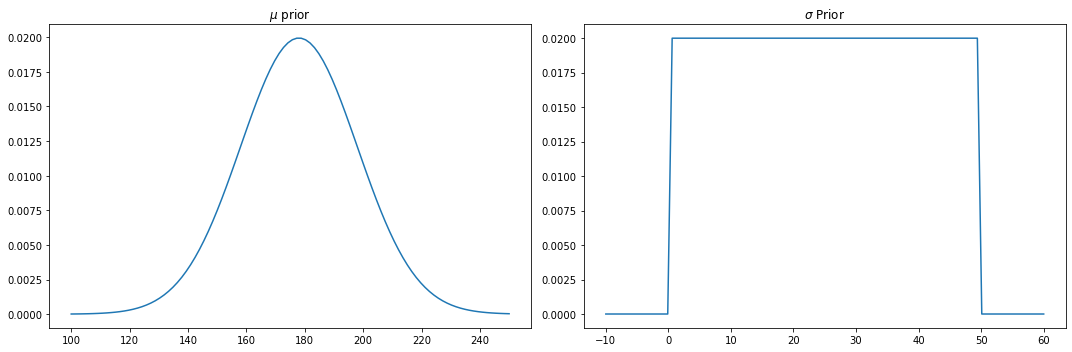

In [52]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].plot(np.linspace(100,250,100), stats.norm.pdf(np.linspace(100,250,100), loc = 178, scale =20))
axs[0].set_title("$\mu$ prior")
axs[1].plot(np.linspace(-10,60,100), stats.uniform.pdf(np.linspace(-10,60,100),0,50))
axs[1].set_title("$\sigma$ Prior")
fig.tight_layout()
plt.show()

To sanity check our priors and what they might imply, we can produce the prior predictive distribution. Our choice of priors implies some plausible distribution of data, $h_i$ equivalent to $Pr(h_i) = \int \int Pr(h_i|\mu,\sigma)Pr(\mu,\sigma) d\mu d\sigma$, where the observations of $h_i$ have here been produced in accordance with the prior distribution. We can approximate this by sampling the priors, and then sampling likelihood in accordance for each element of the prior sample. This gives us an approximation to the prior predictive distribution.

In [59]:
#sample the mu  prior distribution of scale 100
mu1 = np.random.normal(loc = 178, scale = 100, size = 1000)
#sample the mu  prior distribution of scale 20
mu2 = np.random.normal(loc = 178, scale = 20, size = 1000)
#sample the sigma prior distribution
sigma = np.random.uniform(0,50,size = 1000)
#sample the prior predictive height (pp_heights)
pp_heights = np.random.normal(loc = mu, scale  = sigma)

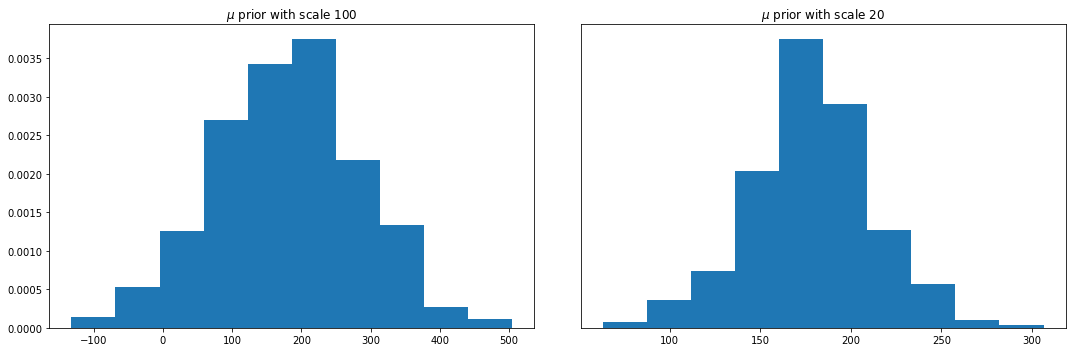

In [66]:
#plot the prior predictive heights implied by the two different priors on the height
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].hist(np.random.normal(loc = mu1, scale  = sigma), density =True)
axs[0].set_title("$\mu$ prior with scale 100")
axs[1].hist(np.random.normal(loc = mu2, scale  = sigma), density =True)
axs[1].set_title("$\mu$ prior with scale 20")
fig.tight_layout()
plt.yticks([])
plt.show()

It can be seen that using the scale 100 prior on $\mu$ can lead to absurd possibilities. This is because there's a non-negligible amount of mass located in the negative region. Our everyday experience informs us that people usually dont possess negative mass. If asked which of the two priors seems more reasonable, we would be strongly inclined to go for the scale 20 prior on $\mu$ as negative outcomes shouldn't be allowed in a model of human heights

#### Obtaining the grid approximation to the 2d posterior distribution

In order to get the grid approximation for all parameter values in the posterior, we need to find a way of getting the set of combination of parameters for which we want to approximate. The one liner below will produce an array containing all pairs of values between 6 and 10 in steps of 0.1 for the standard deviation, $\sigma$ and 150 to 170 for the values of $\mu$, in steps of 0.5.

In [469]:
grid = np.mgrid[150:170:0.1,6:10:0.05].reshape(2,-1).T

Computers struggle to work with very fine grid approximations because the probability of any particular grid point will become vanishingly small and more decimal places will be needed than a typical computer readily has available. This generally results from the many probabilities being the product of other probabilities, all of which are small numbers near zero. This obstacle can be navgiated by working with log probabilities which require few decimal places and transform products of probabilities into sums of log probabilities.

This instead of computing $Pr(\mu,\sigma|Data) = \frac{Pr(Data|\mu,\sigma)Pr(\mu)Pr(\sigma)}{Pr(Data)}$

we instead compute $log(Pr(\mu,\sigma|Data)) \propto log(Pr(Data|\mu,\sigma)) + log(Pr(\mu)) + log(Pr(\sigma)) $

Often the term on the right hand side will be a negative number with a very large magnitude. If you try to exponentiate this your computer will often just give you zero, as exp(-|x|) when x is very large is often very near zero and the compute will just round. This is deeply unhelpful. Instead use the following trick

$Pr(\mu,\sigma|Data) \propto exp(log(Pr(Data|\mu,\sigma)) + log(Pr(\mu)) + log(Pr(\sigma)) + B) = B'exp(log(Pr(Data|\mu,\sigma)) + log(Pr(\mu)) + log(Pr(\sigma))) $

Where B is a large number which your computer will let you exponentiate to give a non-zero. This is equivalent to introducing a scale parameter into your posterior which is shown in the final sum as B'. As this will affect all the terms of your final posterior distribution proportionately, you can get rid of B' simply by by normalising the final probabilities to ensure they sum to one. This is a round about way of navigating the limitations of working with computers. 

I write the grid approximation code longer, more explicit version here, but later I'll simplify it down to 3 lines of code. 

In [477]:
log_posts = []#list to hold posterior probabilities
for params in grid:
    #totallog likelihood of the function
    log_lik_func = np.sum(stats.norm.logpdf(ad_height,loc = params[0],scale = params[1]))
    #log prior probabilities
    prior_mu = stats.norm.logpdf(params[0], loc = 178, scale =20)
    prior_sig = stats.uniform.logpdf(params[1],0,50)
    #sum over these to get the log posterior product
    post_prod = prior_sig + prior_mu + log_lik_func
    #Append this to the log_posts
    log_posts.append(post_prod)
log_posts = np.array(log_posts)#convert list to array
post_probs = np.exp(log_posts + 1000)#Exponentiate with the big number + trick
post_probs = post_probs/np.sum(post_probs)#Normalise

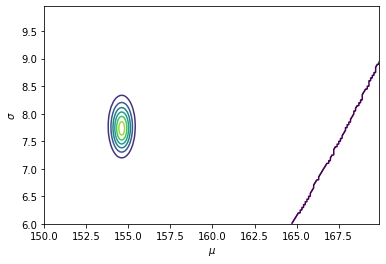

In [478]:
#This is some code I yoiked 
xi = np.linspace(grid[:,0].min(), grid[:,0].max(), 1000)
yi = np.linspace(grid[:,1].min(), grid[:,1].max(), 1000)
zi = griddata((grid[:,0], grid[:,1]), post_probs, (xi[None,:], yi[:,None]))

plt.contour(xi, yi, zi)
plt.ylabel("$\sigma$")
plt.xlabel("$\mu$")
plt.show()

#### Sampling the posterior distribution

Richard McElreath does some sampling by picking a row first then a column. If you shape your posterior paramater and probability arrays appropriately I think that's not necessary. Numpy's random.choice function will largely take care of things for you with an appropriate dictionary.

In [405]:
post_samples = np.random.choice(range(grid.shape[0]), replace = True, p = post_probs, size =100000)

Text(0, 0.5, '$\\sigma$')

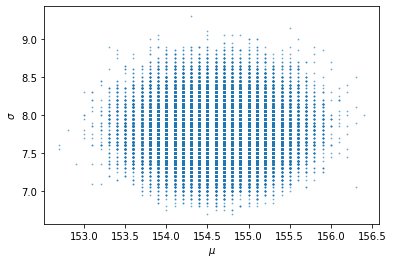

In [427]:
plt.scatter(grid[post_samples,:][:,0], grid[post_samples,:][:,1], s = 0.7, alpha = 0.5 )
plt.xlabel("$\mu$")
plt.ylabel("$\sigma$")

One can then marginalise and observe the distribution for each axis to give the posterior distribution for each of the separate parameters.

In [431]:
#get the kde of the data
func1 = stats.gaussian_kde(grid[post_samples,:][:,0])
func2 = stats.gaussian_kde(grid[post_samples,:][:,1])

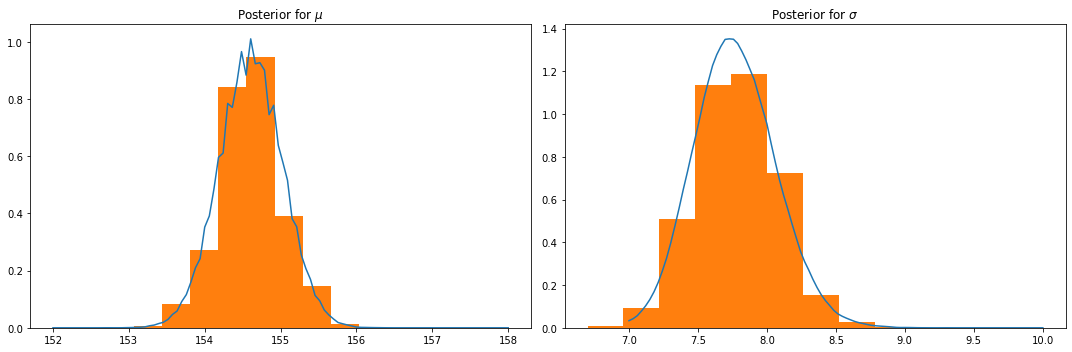

In [438]:
fig, axs = plt.subplots(nrows = 1,ncols = 2, figsize=(15,5))
axs[0].plot(np.linspace(152,158,100),func1(np.linspace(152,158,100)))
axs[0].hist(grid[post_samples,:][:,0],density=True)
axs[0].set_title("Posterior for $\mu$")
axs[1].plot(np.linspace(7,10,100),func2(np.linspace(7,10,100)))
axs[1].hist(grid[post_samples,:][:,1],density=True)
axs[1].set_title("Posterior for $\sigma$")
plt.tight_layout()
plt.show()

As can be seen, the posterior distributions of both data sets look to be approximately gaussian. As noted by McElreath, this behaviour is typically not seen for a small data sets. We repeat the above code for the grid approximation of the posterior but this time using only 20 randomly sampled data points from the adult height data

In [488]:
#get a subset of the adult heights
sub_ad_heights = np.random.choice(ad_height,replace =False, size =20)

We can radically condense the code written above for the posterior

In [493]:
#redefine the parameter grid
grid = np.mgrid[145:170:0.1,6:17:0.05].reshape(2,-1).T
#get the total log_likelihood for all param values
log_lik = np.array([np.sum(stats.norm.logpdf(sub_ad_heights,loc = params[0],scale = params[1])) for params in grid])
#log posterior product
log_posts = stats.norm.logpdf(grid[:,0], loc = 178, scale =20) + stats.uniform.logpdf(grid[:,1],0,50) + log_lik
#convert this into the posterior distribution
post_probs = np.exp(log_posts - np.max(log_posts))#exponentiate with large added factor
post_probs = post_probs/np.sum(post_probs)#Normalise to remove the scale factor

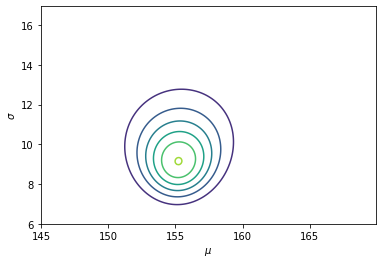

In [494]:
#This is some code I yoiked 
xi = np.linspace(grid[:,0].min(), grid[:,0].max(), 1000)
yi = np.linspace(grid[:,1].min(), grid[:,1].max(), 1000)
zi = griddata((grid[:,0], grid[:,1]), post_probs, (xi[None,:], yi[:,None]))

plt.contour(xi, yi, zi)
plt.ylabel("$\sigma$")
plt.xlabel("$\mu$")
plt.show()

In [495]:
#sample the posterior
post_samples = np.random.choice(range(grid.shape[0]), replace = True, p = post_probs, size =100000)

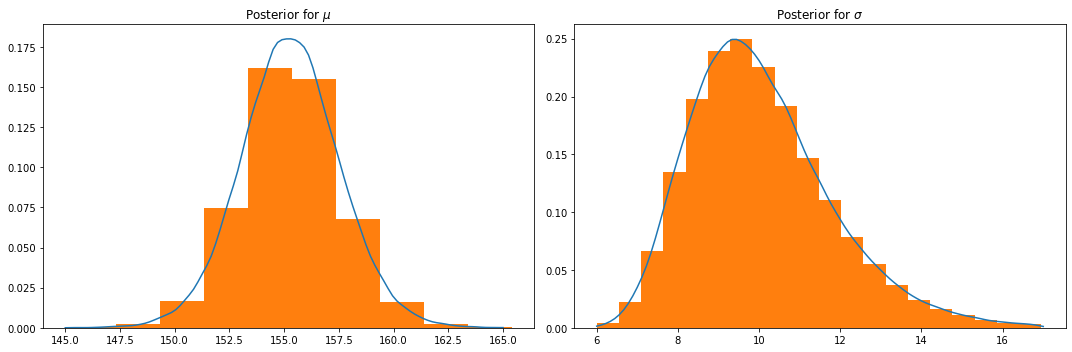

In [498]:
#get the kde of the data
func1 = stats.gaussian_kde(grid[post_samples,:][:,0])
func2 = stats.gaussian_kde(grid[post_samples,:][:,1])
#plot
fig, axs = plt.subplots(nrows = 1,ncols = 2, figsize=(15,5))
axs[0].plot(np.linspace(145,165,100),func1(np.linspace(145,165,100)))
axs[0].hist(grid[post_samples,:][:,0],density=True)
axs[0].set_title("Posterior for $\mu$")
axs[1].plot(np.linspace(6,17,100),func2(np.linspace(6,17,100)))
axs[1].hist(grid[post_samples,:][:,1],density=True, bins = 20)
axs[1].set_title("Posterior for $\sigma$")
plt.tight_layout()
plt.show()

One sees that for the posterior distribution on $\sigma$ the distribution looses some of it's normality due to this small sample size. This is also seen from the skewed longer tail in the contour plot along the y-axis of the data.

#### Laplace's Method

We can make uses of Laplace's method to approximate the posterior distribution of the data. Pymc3 can do most of the heavy lifting for us. We can perform both MCMC with pymc3 and also try to use it to numerically implement Laplace's method.

Without explaining where any of this come's from, Laplaces method states we can approximate the posterior distribution over parameter space using a multidimensional gaussian. This Gaussian will be proportional to $ exp(\frac{1}{2}(\underline{X} - \underline{X}_0)^T \bf{A}$$ (\underline{X} - \underline{X}_0))$, where $A_{i,j} = -\frac{\partial^2 log(P(\underline{X}))}{\partial x_i \partial x_j}$. This $\bf{A}$ matrix can be approximated using the find_hessian function of pymc3. The inverse of this Hessian will be the variance covariance matrix used for laplace's approximation.

logp = -1,235.2, ||grad|| = 11.697: 100%|██████████| 19/19 [00:00<00:00, 58.19it/s]  


{'mu': array(154.60702358), 'sigma_interval__': array(-1.69876478), 'sigma': array(7.73133303)}


Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 3000/3000 [01:24<00:00, 35.61draws/s]
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packa

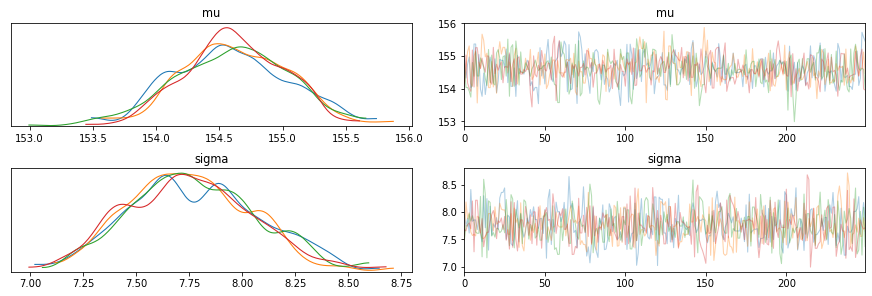

In [511]:
with pm.Model() as m4_1:
    mu = pm.Normal('mu', mu=178, sd=20)#prior on my
    sigma = pm.Uniform('sigma', lower=0, upper=50)#prior on sigma
    height = pm.Normal('height', mu=mu, sd=sigma, observed=ad_height)#likelihood of the data
    mean_q = pm.find_MAP()
    print(mean_q)
    Hess = pm.find_hessian(mean_q, vars=[mu,sigma])#find the hessian matrix
    sample = pm.sample(draws= 250, chains = 4)#1000 random samples on 4 chains
    #get summary reports from the MCMC
    pm.traceplot(sample)
    pm.summary(sample)

In [514]:
#Look athe summary of results from MCMC
pm.summary(sample, credible_interval=0.89 )#obtain summary with 89% credible interval

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,154.609,0.430,153.908,155.234,0.014,0.010,907.0,907.0,890.0,659.0,1.01
sigma,7.766,0.298,7.334,8.273,0.009,0.007,1043.0,1039.0,1040.0,628.0,1.00


In [525]:
trace_df = pm.trace_to_dataframe(sample)
trace_df.cov()#The variance-covariance matrix from MCMC

,mu,sigma
mu,0.184620,0.008687
sigma,0.008687,0.088930


In [527]:
covariance_matrix = np.linalg.inv(Hess)

In [529]:
covariance_matrix, mean_q

(array([[0.16973961, 0.00021803],
        [0.00021803, 0.08490583]]),
 {'mu': array(154.60702358),
  'sigma_interval__': array(-1.69876478),
  'sigma': array(7.73133303)})

As can be seen here, the variance covariance matrix found from both MCMC and Laplace's approximation are comparable. Also, we approximated the mean by the MAP of the posterior, and this also seems sensible compared to the mean from MCMC. We already have samples from MCMC, but we can perform a parametric bootstrap on a multivariate gaussian and compare the distribution to those from MCMC to ensure the validity of this approach.

In [548]:
#sample the multivariate gaussian
means = np.array(list(mean_q.values())[::2])
laplace_sample = np.random.multivariate_normal(means,covariance_matrix, size=1000)

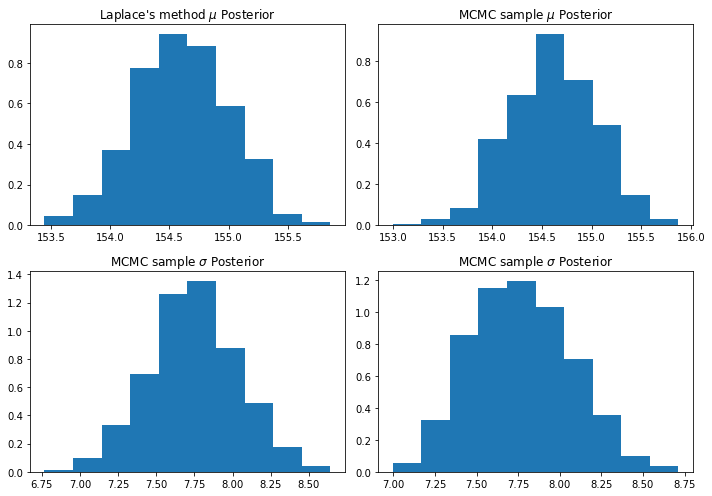

In [562]:
fig, axs = plt.subplots(2,2,figsize = (10,7))
axs[0,0].hist(laplace_sample[:,0], density = True)
axs[0,0].set_title("Laplace's method $\mu$ Posterior")
axs[0,1].hist(trace_df.mu, density = True)
axs[0,1].set_title("MCMC sample $\mu$ Posterior")
axs[1,0].hist(laplace_sample[:,1], density = True)
axs[1,0].set_title("MCMC sample $\sigma$ Posterior")
axs[1,1].hist(trace_df.sigma, density=True)
axs[1,1].set_title("MCMC sample $\sigma$ Posterior")
plt.tight_layout()
plt.show()

Side by side comparison shows that both of these methods are in rough agreement with each other showing broadly similar peaks in their sample distirbutions. For the distribution of $\sigma$ it can be seen that Laplace's method is very symmetric. This is because the samples are drawn explicitly from a multivariate gaussian which imposes it's symmetry on the marginal distribution. MCMC imposes no such constraint on the data, and preserves the fatness of the tail at the upper end of the distribution which is characteristic of posterior distributions in the $\sigma$

### 4.4 Linear prediction

In [47]:
#get the data for the adults
data = howell1[howell1.age >= 18]

<AxesSubplot:xlabel='weight', ylabel='height'>

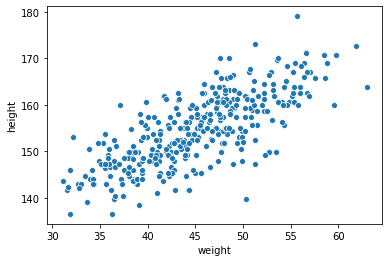

In [7]:
#plot these height against weight
sns.scatterplot(x = "weight", y="height", data=data)

There obviously appears to be a relationship between these two variables.

The general schema of a linear model for height, as predicted by weight is as follows:
    
$H_i$ ~ $N(\mu_i,\sigma^2)$

$\mu_i = \alpha + \beta(x_i - \bar{x})$

$\alpha$ ~ $N(178,20^2)$

$\beta$ ~ $N(0,10)$

$\sigma$ ~ $Unif(0,50)$

The things that makes this a linear model of regression is that the mean of the outcome is linearly dependent on the predictor variable. This is encoded on the second line of the model schema above. This is just a simple model, and one could choose an alternative relationship between the variables.

As we did earlier for this chapter, we can sanity check our priors to see if the predictions they imply for the data cohere with our intuitions for how such a model should behave. We can do this for our $\alpha$ and $\beta$ priors.

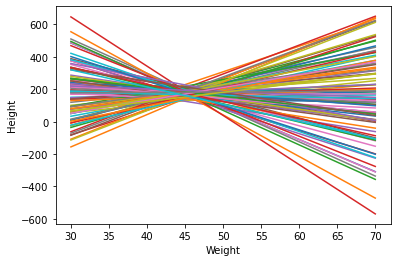

In [13]:
alpha = np.random.normal(loc =178, scale =20, size = 100)
beta = np.random.normal(0,10,100)

for a, b in zip(alpha,beta):
    mu = a + b*(np.linspace(30,70,100) - np.mean(data.weight))
    plt.plot(np.linspace(30,70,100),mu)
plt.xlabel("Weight")
plt.ylabel("Height")
plt.show()

These leads to absurd relationships being plausible between these two parameters. This arises as the gradient parameter, $\beta$ is allowed to take on negative values, as the prior distribution is symmetric about zero. Using the log normal prior encodes the more sensible requirement that this relationship be positive. Let's replot with $\beta$ ~ $Log-N(0,1)$

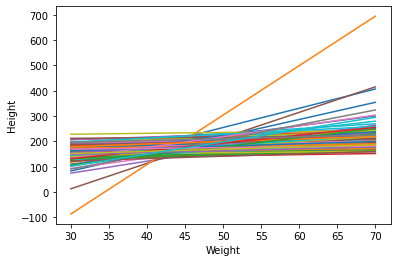

In [14]:
alpha = np.random.normal(loc =178, scale =20, size = 100)
beta = np.random.lognormal(0,1,100)

for a, b in zip(alpha,beta):
    mu = a + b*(np.linspace(30,70,100) - np.mean(data.weight))
    plt.plot(np.linspace(30,70,100),mu)
plt.xlabel("Weight")
plt.ylabel("Height")
plt.show()

This is a significant improvement to our earlier model. The log normal prior has eradicated the negative relationships. Absurd outcomes still occur, such as negative heights, but these are so rare relative to the sensible predictions that this isn't necessarily a problem, especially once the model has been trained on the data.

We can now try to fit this model to the data using pymc3 and the quadratic approximation:

logp = -1,080.4, ||grad|| = 5.147: 100%|██████████| 39/39 [00:01<00:00, 26.60it/s]   


{'alpha': array(154.60136748), 'beta_log__': array(-0.10172172), 'sigma_interval__': array(-2.18135226), 'beta': array(0.90328088), 'sigma': array(5.07188029)}


Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 3000/3000 [03:53<00:00, 12.84draws/s]
The acceptance probability does not match the target. It is 0.8876849870738664, but should be close to 0.8. Try to increase the number of tuning steps.
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/aidan/anaconda3/envs/Bayes/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argu

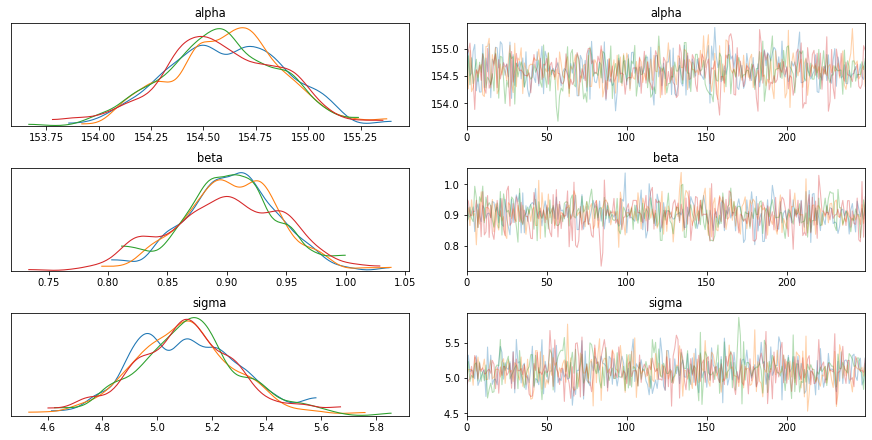

In [48]:
with pm.Model() as m4_1:
    alpha = pm.Normal('alpha', mu=178, sd=20)#prior on alpha
    beta = pm.Lognormal("beta", mu=0,tau=1)#prior on beta
    sigma = pm.Uniform("sigma",0,50)#prior on sigma
    mu = alpha + beta*(data.weight.values - np.mean(data.weight.values))
    height = pm.Normal('height', mu=mu, sd=sigma, observed=data.height)#likelihood of the data
    mean_q = pm.find_MAP()
    print(mean_q)
    Hess = pm.find_hessian(mean_q, vars=[alpha, beta,sigma])#find the hessian matrix
    sample = pm.sample(draws= 250, chains = 4)#1000 random samples on 4 chains
    #get summary reports from the MCMC
    pm.traceplot(sample)
    pm.summary(sample)

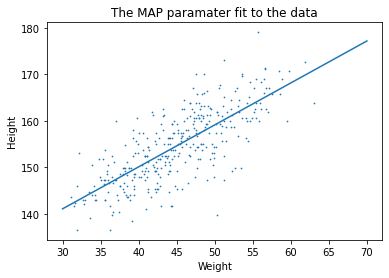

In [91]:
mu = mean_q["alpha"] + mean_q["beta"]*(np.linspace(30,70,100) - np.mean(data.weight))
plt.plot(np.linspace(30,70,100) , mu)
plt.scatter(data.weight,data.height, s = 0.5)
plt.title("The MAP paramater fit to the data")
plt.xlabel("Weight")
plt.ylabel("Height")
plt.show()

In [56]:
var_cov = np.linalg.inv(Hess)

In [65]:
var_cov, mean_q

(array([[ 7.30662139e-02, -4.24555364e-08,  6.15849250e-05],
        [-4.24555364e-08,  1.75797565e-03, -2.51901144e-05],
        [ 6.15849250e-05, -2.51901144e-05,  3.65401415e-02]]),
 {'alpha': array(154.60136748),
  'beta_log__': array(-0.10172172),
  'sigma_interval__': array(-2.18135226),
  'beta': array(0.90328088),
  'sigma': array(5.07188029)})

As the Laplace's method approximates with a normal distribution, we can simply get the get the 89% compatability interval of the $\beta$ parameter by finding the central 89% interval of a gaussian with the location and scale parameters found from the quadratic approximation.

In [59]:
stats.norm.interval(0.89, loc = mean_q["beta"], scale = np.sqrt(var_cov[1,1]))

(0.8362714833331466, 0.9702902711375507)

The off diagonal elements of the covariance matrix are negligible. Therefore one expects only a week correlation to be found between these paramater values. Using the multivatiate gaussian approximation to the posterior, we can take samples of the line parameters of the posterior and plot them against the actual data.

In [72]:
means = np.fromiter(mean_q.values(), dtype=float)[[0,3,4]]

In [74]:
post_samples = np.random.multivariate_normal(means, var_cov,size = 100)

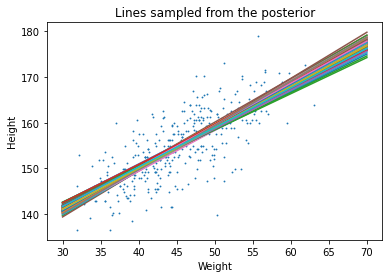

In [79]:
#taking only the alpha & beta from sample, we can plot the lines
for params in post_samples:
    mu = params[0] + params[1]*(np.linspace(30,70,100) - np.mean(data.weight))
    plt.plot(np.linspace(30,70,100),mu)
plt.scatter(data.weight,data.height, s = 0.7)
plt.xlabel("Weight")
plt.ylabel("Height")
plt.title("Lines sampled from the posterior")
plt.show()

Instead of sampling paramaters from the posterior and then plotting all of the resulting lines, we may simply plot a contour which captures a certain amount of mass for each of these lines.

The procedure is to take many samples of the data, compute the distribution of values of $\mu$ that these parameters would imply for each value for weight, and find the central credibility interval at each value. The two lines beneath do this automatically.

In [89]:
#resample for posterior for 10,000 sample
post_samples = np.random.multivariate_normal(means, var_cov,size = 10000)
#compute the hpdi for a range of weight values
cred_intervals = np.array([pm.hpd(post_samples[:,0] + post_samples[:,1]*(x - np.mean(data.weight)), credible_interval =0.89) for x in np.linspace(30,70)])


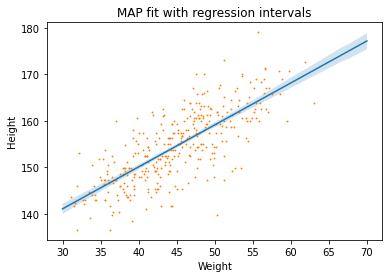

In [97]:
plt.fill_between(np.linspace(30,70), cred_intervals[:,0], cred_intervals[:,1],alpha = 0.2)
plt.plot(np.linspace(30,70,100) , mu)
plt.scatter(data.weight,data.height, s = 0.7)
plt.xlabel("Weight")
plt.ylabel("Height")
plt.title("MAP fit with regression intervals")
plt.show()

We may also wish to know the prediction intervals on the data. The plot above captures our uncertainty in the paramater values, as given by the posterior distribution. However, we would also like to know incorporate our uncertainty in the range of height outcomes at any given value of weight. This is captured by $\sigma$ in our model. This is given by the posterior predictive distribution at each value.

In [114]:
#define a function to compute mu for all posterior samples at given value of x
def compute_mu(x):
    return post_samples[:,0] + post_samples[:,1]*(x - np.mean(data.weight))
#compute the prediction interval in one line
pred_intervals = np.array([pm.hpd(np.random.normal(loc = compute_mu(x), scale = post_samples[:,2]),credible_interval = 0.89) for x in np.linspace(30,70)])

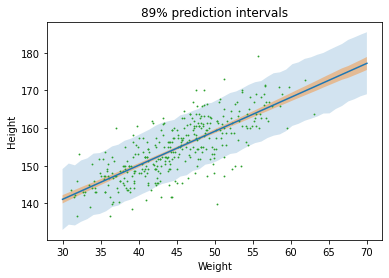

In [119]:
plt.fill_between(np.linspace(30,70), pred_intervals[:,0], pred_intervals[:,1],alpha = 0.2)
plt.fill_between(np.linspace(30,70), cred_intervals[:,0], cred_intervals[:,1],alpha = 0.4)
plt.plot(np.linspace(30,70,100) , mu)
plt.scatter(data.weight,data.height, s = 0.7)
plt.xlabel("Weight")
plt.ylabel("Height")
plt.title("89% prediction intervals")
plt.show()

### 4.5 Curves from lines

#### Polynomial regression

<AxesSubplot:xlabel='weight', ylabel='height'>

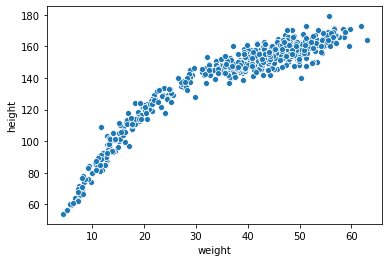

In [122]:
sns.scatterplot(x="weight",y="height",data=howell1)

It can be seen that the weight-height relationship looks far less linear when we investigate the entire age range of the data. Instead of modelling the mean height as have a linear dependence on the weight we could try a non-linear function such as a quadratic polynomial. This is all encapsulated in the following model:

    
$H_i$ ~ $N(\mu_i,\sigma^2)$

$\mu_i = \alpha + \beta_1 x_i + \beta_2x_i^2$

$\alpha$ ~ $N(178,20^2)$

$\beta_1$ ~ $Log-N(0,1)$

$\beta_2$ ~ $N(0,1)$

$\sigma$ ~ $Unif(0,50)$

We can again implement this model with pymc3 and get a linear approximation to the posteriors. Additionally, we can pre-process the height variables before feeding it into the model

In [127]:
#standardise the weight features
stand_weight = (howell1.weight.values - np.mean(howell1.weight.values))/np.std(howell1.weight.values)
#get the squares
stand_weight2 = stand_weight**2

In [218]:
with pm.Model() as poly_fit:
    alpha = pm.Normal('alpha', mu=178, sd=20)#prior on alpha
    beta1 = pm.Lognormal("beta1", mu=0,tau=1)#prior on beta1
    beta2 = pm.Normal("beta2", mu=0,sd =1)#prior on beta2
    sigma = pm.Uniform("sigma",0,50)#prior on sigma
    mu = alpha + beta1 * stand_weight + beta2 * stand_weight2
    height = pm.Normal('height', mu=mu, sd=sigma, observed=howell1.height)#likelihood of the data
    mean_q = pm.find_MAP()
    print(mean_q)
    Hess = pm.find_hessian(mean_q, vars=[alpha, beta1,beta2,sigma])#find the hessian matrix
    #sample = pm.sample(draws= 250, chains = 4)#1000 random samples on 4 chains
    #get summary reports from the MCMC
#     pm.traceplot(sample)
#     pm.summary(sample)

logp = -1,774.9, ||grad|| = 7.2889: 100%|██████████| 55/55 [00:05<00:00, 10.50it/s]   


{'alpha': array(146.05954091), 'beta1_log__': array(3.07786169), 'beta2': array(-7.79107056), 'sigma_interval__': array(-2.0358917), 'beta1': array(21.7119259), 'sigma': array(5.77428635)}


In [219]:
var_cov = np.linalg.inv(Hess)

In [220]:
mean_q, var_cov

({'alpha': array(146.05954091),
  'beta1_log__': array(3.07786169),
  'beta2': array(-7.79107056),
  'sigma_interval__': array(-2.0358917),
  'beta1': array(21.7119259),
  'sigma': array(5.77428635)},
 array([[ 0.13613615, -0.04054857, -0.07487598, -0.00599612],
        [-0.04054857,  0.08325656,  0.04056011,  0.00315399],
        [-0.07487598,  0.04056011,  0.07489767,  0.0060496 ],
        [-0.00599612,  0.00315399,  0.0060496 ,  0.03113427]]))

In [221]:
#Approx means with MAP
means = np.fromiter(mean_q.values(), dtype=float)[[0,4,2,5]]
#Draw samples from the posterior distribution
post_samples = np.random.multivariate_normal(means, var_cov, size =1000)


In [222]:
#define a function to return the polynomial values
def comp_mu(x):
    return post_samples[:,0] + post_samples[:,1] * x + post_samples[:,2]* x**2

In [223]:
#define the range of standard weight values to compute over
low = stand_weight.min()
high = stand_weight.max()
#compute the 89% credible interval for each value in the range
cred_intervals = np.array([ pm.hpd(comp_mu(x),credible_interval=0.89) for x in np.linspace(low,high)])
#compute the 89% prediction for each value in the range
pred_intervals= np.array([ pm.hpd(np.random.normal(comp_mu(x), post_samples[:,3]),credible_interval=0.89) for x in np.linspace(low,high)])

In [228]:
def mu_func(alpha, beta1, beta2):
    return lambda x : alpha + beta1 * x + beta2 * x**2
#define the curve with map values
map_mu = mu_func(mean_q["alpha"],mean_q["beta1"],mean_q["beta2"])

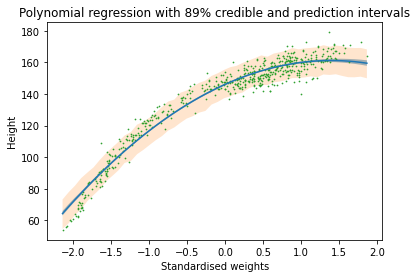

In [229]:
#We can view the MAP predictions in the standardised weight basis
plt.title("Polynomial regression with 89% credible and prediction intervals")
plt.plot(np.linspace(stand_weight.min(),stand_weight.max()),map_mu(np.linspace(stand_weight.min(),stand_weight.max())))
plt.fill_between(np.linspace(stand_weight.min(),stand_weight.max()),cred_intervals[:,0],cred_intervals[:,1],alpha=0.5)
plt.fill_between(np.linspace(stand_weight.min(),stand_weight.max()),pred_intervals[:,0],pred_intervals[:,1],alpha=0.2)
plt.scatter(stand_weight, howell1.height, s = 0.5)
plt.xlabel("Standardised weights")
plt.ylabel("Height")
plt.show()

We can replot this on the original length scale of the data to make the predictions more interpretable.

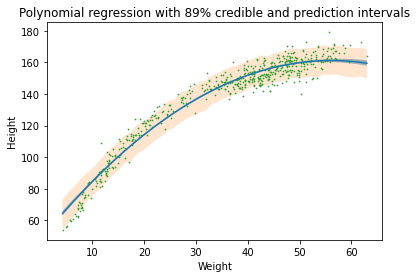

In [232]:
#We can view the MAP predictions in the standardised weight basis
plt.title("Polynomial regression with 89% credible and prediction intervals")
plt.plot(np.linspace(howell1.weight.min(),howell1.weight.max()),map_mu(np.linspace(stand_weight.min(),stand_weight.max())))
plt.fill_between(np.linspace(howell1.weight.min(),howell1.weight.max()),cred_intervals[:,0],cred_intervals[:,1],alpha=0.5)
plt.fill_between(np.linspace(howell1.weight.min(),howell1.weight.max()),pred_intervals[:,0],pred_intervals[:,1],alpha=0.2)
plt.scatter(howell1.weight, howell1.height, s = 0.5)
plt.xlabel("Weight")
plt.ylabel("Height")
plt.show()

#### Splines

## Chapter 4

### End of chapter problems

4E1. In the model definition below, which line is the likelihood?

yi ∼ Normal(µ, σ)

µ ∼ Normal(0, 10)

σ ∼ Exponential(1)

Answer: The first line defines the likelihood

4E2. In the model definition just above, how many parameters are in the posterior distribution?

Answer: There are two parameters in the posterior, $\mu $ and $\sigma$

4E3. Using the model definition above, write down the appropriate form of Bayes’ theorem that includes the proper likelihood and priors

Answer: 

$ Pr(\mu,\sigma) = \frac{Pr(\underline{h}|\mu,\sigma)Pr(\mu)Pr(\sigma)}{Pr(\underline{h})} \propto \frac{1}{\sigma}\prod_i exp(-\frac{1}{2}(\frac{h_i - \mu}{\sigma})^2) \times  exp(-\frac{1}{2}(\frac{\mu}{10})^2) \times exp(-\sigma)$

$ \implies Pr(\mu,\sigma) = \frac{\frac{1}{\sigma}\prod_i exp(-\frac{1}{2}(\frac{h_i - \mu}{\sigma})^2)exp(-\frac{1}{2}(\frac{\mu}{10})^2)exp(-\sigma)}{\int \int \frac{1}{\sigma}\prod_i exp(-\frac{1}{2}(\frac{h_i - \mu}{\sigma})^2)exp(-\frac{1}{2}(\frac{\mu}{10})^2)exp(-\sigma) d\mu d\sigma}$

4E4. In the model definition below, which line is the linear model?
yi ∼ Normal(µ, σ)

µi = α + βxi

α ∼ Normal(0, 10)

β ∼ Normal(0, 1)

σ ∼ Exponential(2)

Answer: The second line. It encodes the linear dependence of the mean of the likelihood on the predictor variable, xi

4E5. In the model definition just above, how many parameters are in the posterior distribution?

Answer: There are three paramaters in the posterior distribution. $\alpha$, $\beta$, and $\sigma$.

4M1. For the model definition below, simulate observed y values from the prior (not the posterior).

yi ∼ Normal(µ, σ)

µ ∼ Normal(0, 10)

σ ∼ Exponential(1)

In [187]:
#simulate the prior predictive distribution for 1,000 samples
mu = np.random.normal(0,10,size=1000)#prior for mu
sigma = np.random.exponential(1,size=1000)#prior for sigma
#get the samples from the likelihood
y = np.random.normal(mu,sigma)

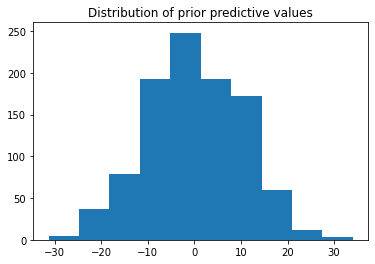

In [189]:
plt.title("Distribution of prior predictive values")
plt.hist(y)
plt.show()

4M2. Translate the model just above into a quap formula.

Answer: N/A. This is a function in the statistical rethinking R package

4M3: Ditto

4M4. A sample of students is measured for height each year for 3 years. After the third year, you want to fit a linear regression predicting height using year as a predictor. Write down the mathematical
model definition for this regression, using any variable names and priors you choose. Be prepared to
defend your choice of priors.

Answer:

I'm assuming these are young students who grow linearly with time

Let $h_i, y, \sigma$ be height, year/time since first measurement, mean and standard deviation respectively

$h_i$ ~ $N(\mu,\sigma^2)$ #As height is roughly normally distributed and the variance is constant with age. On a 3 year time scale, and for a simple model, I don't see why height variance would alter substantially with age. This is a sketchy assumption, and one could opt to include some temporal dependence in the variance.

$\mu = \alpha + \beta y$ #Assume the mean has some linear dependence on time

$\alpha$ ~ $N(1,0.1^2)$ #Assume the students are toddlers around the 1 metre height mark at the start of the measuring time. The standard deviation allows for a considerable range of heights, but nothing to fantastical like 0 or 2 metres tall.

$\beta$ ~ $log-N(0,1)$ #It seems perfectly sensible that the amount an average students height changes per year should only be positive. Additionally, I have no idea what the growth rate is so this enocodes ignorance about the rate of change of height per year

$\sigma$ ~ $Unif(0,50)$

4M5. Now suppose I remind you that every student got taller each year. Does this information lead
you to change your choice of priors? How?

Answer: No it does not. I already factored this in.

4M6. Now suppose I tell you that the variance among heights for students of the same age is never
more than 64cm. How does this lead you to revise your priors?

Answer: This would cause me to use an even larger range of plausable values in my prior for $\sigma$. Given my assumption for the students ages, increasing the range seems to be not sensible for the data at hand.

4M7. Refit model m4.3 from the chapter, but omit the mean weight xbar this time. Compare the
new model’s posterior to that of the original model. In particular, look at the covariance among the
parameters. What is different? Then compare the posterior predictions of both models.

In [4]:
with pm.Model() as m4_1:
    alpha = pm.Normal('alpha', mu=178, sd=20)#prior on alpha
    beta = pm.Lognormal("beta", mu=0,tau=1)#prior on beta
    sigma = pm.Uniform("sigma",0,50)#prior on sigma
    mu = alpha + beta*data.weight.values
    height = pm.Normal('height', mu=mu, sd=sigma, observed=data.height)#likelihood of the data
    mean_q = pm.find_MAP()
    print(mean_q)
    Hess = pm.find_hessian(mean_q, vars=[alpha, beta,sigma])#find the hessian matrix


logp = -1,084.7, ||grad|| = 0.010016: 100%|██████████| 53/53 [00:02<00:00, 25.20it/s]       


{'alpha': array(114.5342983), 'beta_log__': array(-0.11571346), 'sigma_interval__': array(-2.18116842), 'beta': array(0.89073042), 'sigma': array(5.07271819)}


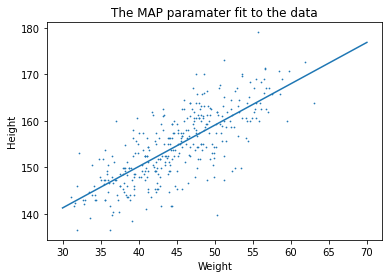

In [5]:
mu = mean_q["alpha"] + mean_q["beta"]*(np.linspace(30,70,100))
plt.plot(np.linspace(30,70,100) , mu)
plt.scatter(data.weight,data.height, s = 0.5)
plt.title("The MAP paramater fit to the data")
plt.xlabel("Weight")
plt.ylabel("Height")
plt.show()

In [6]:
var_cov = np.linalg.inv(Hess)

In [7]:
np.mean(data.weight)*0.9 + mean_q["alpha"]

155.02573526795243

In [8]:
var_cov, mean_q

(array([[ 3.60234135e+00, -7.84577731e-02,  9.35920754e-03],
        [-7.84577731e-02,  1.74417272e-03, -2.04346410e-04],
        [ 9.35920754e-03, -2.04346410e-04,  3.65761511e-02]]),
 {'alpha': array(114.5342983),
  'beta_log__': array(-0.11571346),
  'sigma_interval__': array(-2.18116842),
  'beta': array(0.89073042),
  'sigma': array(5.07271819)})

As the Laplace's method approximates with a normal distribution, we can simply get the get the 89% compatability interval of the $\beta$ parameter by finding the central 89% interval of a gaussian with the location and scale parameters found from the quadratic approximation.

In [9]:
stats.norm.interval(0.89, loc = mean_q["beta"], scale = np.sqrt(var_cov[1,1]))

(0.8239846054490241, 0.9574762251135323)

The off diagonal elements of the covariance matrix are negligible. Therefore one expects only a week correlation to be found between these paramater values. Using the multivatiate gaussian approximation to the posterior, we can take samples of the line parameters of the posterior and plot them against the actual data.

In [10]:
means = np.fromiter(mean_q.values(), dtype=float)[[0,3,4]]

In [11]:
#resample for posterior for 10,000 sample
post_samples = np.random.multivariate_normal(means, var_cov,size = 10000)
#compute the hpdi for a range of weight values
cred_intervals = np.array([pm.hpd(post_samples[:,0] + post_samples[:,1]*(x), credible_interval =0.89) for x in np.linspace(30,70)])


We may also wish to know the prediction intervals on the data. The plot above captures our uncertainty in the paramater values, as given by the posterior distribution. However, we would also like to know incorporate our uncertainty in the range of height outcomes at any given value of weight. This is captured by $\sigma$ in our model. This is given by the posterior predictive distribution at each value.

In [12]:
#define a function to compute mu for all posterior samples at given value of x
def compute_mu(x):
    return post_samples[:,0] + post_samples[:,1]*(x)
#compute the prediction interval in one line
pred_intervals = np.array([pm.hpd(np.random.normal(loc = compute_mu(x), scale = post_samples[:,2]),credible_interval = 0.89) for x in np.linspace(30,70)])

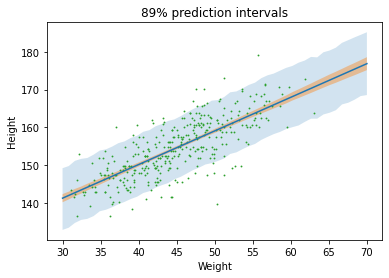

In [13]:
plt.fill_between(np.linspace(30,70), pred_intervals[:,0], pred_intervals[:,1],alpha = 0.2)
plt.fill_between(np.linspace(30,70), cred_intervals[:,0], cred_intervals[:,1],alpha = 0.4)
plt.plot(np.linspace(30,70,100) , mu)
plt.scatter(data.weight,data.height, s = 0.7)
plt.xlabel("Weight")
plt.ylabel("Height")
plt.title("89% prediction intervals")
plt.show()

It can be seen that the predictions and the posterior values themselves look rather similar to each other. However the in the variance-covariance matrix appear to be a couple of orders of magnitude larger when one doesn't subtract the mean values from the data. Why is this? It's because the parameters signify different things in the two different situations. 

Inspect the model again:

Originally we had 

$\mu_i = \alpha + \beta(x_i - \bar{x})$

and in the second run we are instead deciding to fit

$\mu_i = \alpha' + \beta x_i$

We can see that doing this in no way changes the model that is being fit to the data as we can derive one from the other as follows

$\mu_i = \alpha + \beta(x_i - \bar{x}) = \alpha - \beta \bar{x} + \beta x_i = \alpha' + \beta x_i$

That is to say

$ \alpha' = \alpha - \beta \bar{x}$

So as we can see, we can literally derive one parameter from the other. So why is the variance and covariance for the posterior of $\alpha'$ so much larger than for $\alpha$? It's because of what these parameters represent. For $\alpha$, it can be seen that $\mu = \alpha$ when $x = \bar{x}$. That is $\alpha$ represents the mean height at the mean weight. Therefore, the uncertainty in $\alpha$ is equivalent to the uncertainty in $\mu$ when $x = \bar{x}$, the mean of the weight. On the other hand, $\mu = \alpha'$ when $x = 0$, that is $\alpha$ represent the y-intercept of the data. Inspecting the plot below makes it much clearer what is going on here.

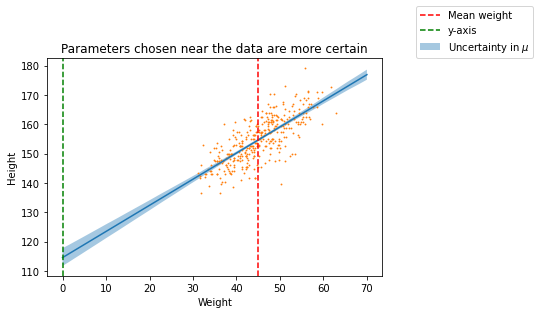

In [30]:
mu = mean_q["alpha"] + mean_q["beta"]*(np.linspace(0,70,100))
cred_intervals = np.array([pm.hpd(post_samples[:,0] + post_samples[:,1]*(x), credible_interval =0.89) for x in np.linspace(0,70)])
plt.fill_between(np.linspace(0,70), cred_intervals[:,0], cred_intervals[:,1],alpha = 0.4, label="Uncertainty in $\mu$")
plt.plot(np.linspace(0,70,100) , mu)
plt.scatter(data.weight,data.height, s = 0.7)
plt.xlabel("Weight")
plt.ylabel("Height")
plt.axvline(np.mean(data.weight), ls="--",c="r", label="Mean weight")
plt.axvline(0, ls="--",c="g", label="y-axis")
plt.title("Parameters chosen near the data are more certain")
plt.legend(loc=(1.1,1))
plt.show()

It can be clearly seen that the uncertainty in the parameter in $\mu$ and therefore $\alpha'$ is much larger at the y intercept. This is represented by the larger hpdi band near the green line. On the the hpdi near the mean weight is very narrow. Intuitively is because there's no data near the y intercept, therefore the uncertainty in this region is far less constrained by our observations compared to the uncertainy near $\mu$ where data abounds.

# Come back and do the Splines (if interested)

I am time limited and splines don't seem obviously useful to me at this point and they aren't referenced in the rest of the book outside of chapter 4. I will return to them at a future date.

4H1. The weights listed below were recorded in the !Kung census, but heights were not recorded for
these individuals. Provide predicted heights and 89% intervals for each of these individuals. That is,
fill in the table below, using model-based predictions.

| Individual | Weight | Expected height | 89% interval|
|------|------|-------|-----|
|   1  | 46.95|?|?|
|   2  | 43.72|?|?|
|   3  | 64.78|?|?|
|   4  | 32.59|?|?|
|   5  | 54.63|?|?|

In [54]:
#define the data
individuals = np.linspace(1,5,5)
weight = np.array([ 46.95, 43.72, 64.78, 32.59, 54.63])
#compute the mean predictions
means = mean_q["alpha"] + mean_q["beta"]*weight
#compute the prediction intervals
pred_intervals = np.array([pm.hpd(np.random.normal(loc = compute_mu(x), scale = post_samples[:,2]),credible_interval = 0.89) for x in weight])
data_dict = {"Individual": individuals, "Weight": weight, "Expected height": means, "Low_interval": pred_intervals[:,0],"Upper_interval": pred_intervals[:,1]}

In [55]:
#present everything in a pandas dataframe
pd.DataFrame(data=data_dict)

,Individual,Weight,Expected height,Low_interval,Upper_interval
0,1.0,46.95,156.354091,148.130043,164.553954
1,2.0,43.72,153.477032,145.032898,161.315818
2,3.0,64.78,172.235815,163.847054,180.455506
3,4.0,32.59,143.563203,135.431839,151.633192
4,5.0,54.63,163.194901,155.213889,171.273458


4H2. Select out all the rows in the Howell1 data with ages below 18 years of age. If you do it right,
you should end up with a new data frame with 192 rows in it.

(a) Fit a linear regression to these data, using quap. Present and interpret the estimates. For
every 10 units of increase in weight, how much taller does the model predict a child gets?

(b) Plot the raw data, with height on the vertical axis and weight on the horizontal axis. Superimpose the MAP regression line and 89% interval for the mean. Also superimpose the 89% interval
for predicted heights.

(c) What aspects of the model fit concern you? Describe the kinds of assumptions you would
change, if any, to improve the model. You don’t have to write any new code. Just explain what the
model appears to be doing a bad job of, and what you hypothesize would be a better model.



In [56]:
#get the young data
y_data = howell1[howell1.age<18]

In [57]:
#check the correct amount of data is present
y_data.shape

(192, 4)

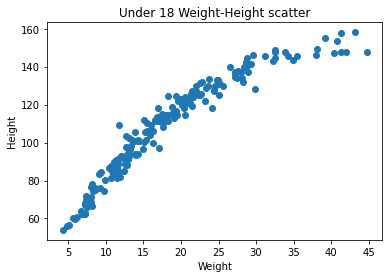

In [60]:
#check out the data
plt.scatter(y_data.weight, y_data.height)
plt.xlabel("Weight")
plt.ylabel("Height")
plt.title("Under 18 Weight-Height scatter")
plt.show()

I lazily fit the same model from earlier

$H_i$ ~ $N(\mu_i,\sigma^2)$

$\mu_i = \alpha + \beta(x_i - \bar{x})$

$\alpha$ ~ $log-N(178,20^2)$

$\beta$ ~ $N(0,10)$

$\sigma$ ~ $Unif(0,50)$

In [73]:
np.mean(y_data.weight.values)

18.414193058854167

In [78]:
#obtain a linear model with Laplace's approximation
with pm.Model() as m4_1:
    alpha = pm.Normal('alpha', mu=178, sd=20)#prior on alpha
    beta = pm.Lognormal("beta", mu=0,tau=1)#prior on beta
    sigma = pm.Uniform("sigma",0,50)#prior on sigma
    mu = alpha + beta*(y_data.weight.values - np.mean(y_data.weight.values))
    height = pm.Normal('height', mu=mu, sd=sigma, observed=y_data.height.values)#likelihood of the data
    mean_q = pm.find_MAP()
    print(mean_q)
    Hess = pm.find_hessian(mean_q, vars=[alpha, beta,sigma])#find the hessian matrix

logp = -1,139.3, ||grad|| = 512.16: 100%|██████████| 21/21 [00:00<00:00, 46.62it/s]  


{'alpha': array(110.51577411), 'beta_log__': array(0.95429403), 'sigma_interval__': array(36.49940751), 'beta': array(2.59683665), 'sigma': array(50.)}


<ipython-input-85-178b569c79fe>:4: RuntimeWarning: covariance is not positive-semidefinite.
  post_samples = np.random.multivariate_normal(means, var_cov,size = 10000)


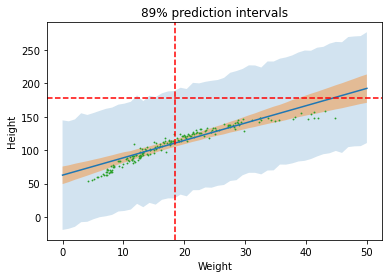

In [85]:
var_cov = np.linalg.inv(Hess)
means = np.fromiter(mean_q.values(), dtype=float)[[0,3,4]]
#resample for posterior for 10,000 sample
post_samples = np.random.multivariate_normal(means, var_cov,size = 10000)
#compute the hpdi for a range of weight values
cred_intervals = np.array([pm.hpd(post_samples[:,0] + post_samples[:,1]*(x - np.mean(y_data.weight)), credible_interval =0.89) for x in np.linspace(0,50)])
#define a function to compute mu for all posterior samples at given value of x
def compute_mu(x):
    return post_samples[:,0] + post_samples[:,1]*(x - np.mean(y_data.weight) )
#compute the prediction interval in one line
mu = mean_q["alpha"] + mean_q["beta"]*(np.linspace(0,50,100)- np.mean(y_data.weight) )
pred_intervals = np.array([pm.hpd(np.random.normal(loc = compute_mu(x), scale = post_samples[:,2]),credible_interval = 0.89) for x in np.linspace(0,50)])
plt.fill_between(np.linspace(0,50), pred_intervals[:,0], pred_intervals[:,1],alpha = 0.2)
plt.fill_between(np.linspace(0,50), cred_intervals[:,0], cred_intervals[:,1],alpha = 0.4)
plt.plot(np.linspace(0,50,100) , mu)
plt.scatter(y_data.weight,y_data.height, s = 0.7)
plt.xlabel("Weight")
plt.ylabel("Height")
plt.title("89% prediction intervals")
plt.axvline(np.mean(y_data.weight), ls="--",c="r", label="Mean weight")
plt.axhline(178, ls="--",c="r", label="Mean weight")
plt.show()

As can be seen, this gives absurdly large prediction intervals. This is because I chose a stupid prior for $\alpha$ which is the mean height at the mean weight. This is indicated by the crossover of the red lines above. If set the prior as 

$\alpha$ ~ $N(100,20^2)$

and then re-run everything, we see that we get far more sensible results for the data.

In [86]:
#obtain a linear model with Laplace's approximation
with pm.Model() as m4_1:
    alpha = pm.Normal('alpha', mu=100, sd=20)#prior on alpha
    beta = pm.Lognormal("beta", mu=0,tau=1)#prior on beta
    sigma = pm.Uniform("sigma",0,50)#prior on sigma
    mu = alpha + beta*(y_data.weight.values - np.mean(y_data.weight.values))
    height = pm.Normal('height', mu=mu, sd=sigma, observed=y_data.height.values)#likelihood of the data
    mean_q = pm.find_MAP()
    print(mean_q)
    Hess = pm.find_hessian(mean_q, vars=[alpha, beta,sigma])#find the hessian matrix

logp = -692.24, ||grad|| = 0.12841: 100%|██████████| 24/24 [00:00<00:00, 43.27it/s]  


{'alpha': array(108.31115082), 'beta_log__': array(0.99940212), 'sigma_interval__': array(-1.5945605), 'beta': array(2.71665711), 'sigma': array(8.4371617)}


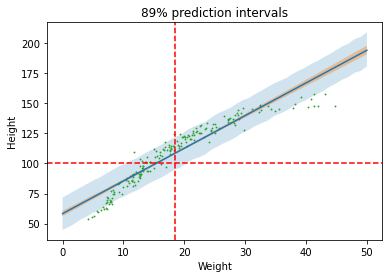

In [88]:
var_cov = np.linalg.inv(Hess)
means = np.fromiter(mean_q.values(), dtype=float)[[0,3,4]]
#resample for posterior for 10,000 sample
post_samples = np.random.multivariate_normal(means, var_cov,size = 10000)
#compute the hpdi for a range of weight values
cred_intervals = np.array([pm.hpd(post_samples[:,0] + post_samples[:,1]*(x - np.mean(y_data.weight)), credible_interval =0.89) for x in np.linspace(0,50)])
#define a function to compute mu for all posterior samples at given value of x
def compute_mu(x):
    return post_samples[:,0] + post_samples[:,1]*(x - np.mean(y_data.weight) )
#compute the prediction interval in one line
mu = mean_q["alpha"] + mean_q["beta"]*(np.linspace(0,50,100)- np.mean(y_data.weight) )
pred_intervals = np.array([pm.hpd(np.random.normal(loc = compute_mu(x), scale = post_samples[:,2]),credible_interval = 0.89) for x in np.linspace(0,50)])
plt.fill_between(np.linspace(0,50), pred_intervals[:,0], pred_intervals[:,1],alpha = 0.2)
plt.fill_between(np.linspace(0,50), cred_intervals[:,0], cred_intervals[:,1],alpha = 0.4)
plt.plot(np.linspace(0,50,100) , mu)
plt.scatter(y_data.weight,y_data.height, s = 0.7)
plt.xlabel("Weight")
plt.ylabel("Height")
plt.title("89% prediction intervals")
plt.axvline(np.mean(y_data.weight), ls="--",c="r", label="Mean weight")
plt.axhline(100, ls="--",c="r", label="Mean weight")
plt.show()

This is a much better fit and the narrow prediction intervals reflect this. The model is still poor in many regards. This includes the failure of the model to capture the non-linear variation of height with weight, which results in poor predictions at the extreme ends of the distribution. The reason the linearity breaks down is fairly intuitive. If I over consume food, my weight will go up, but my height will not. This is an obvious contributing factor to weight, but not height that violates the linear assumption. Trying a non-linear model would help aid in the prediction at the tails.

4H3. Suppose a colleague of yours, who works on allometry, glances at the practice problems just
above. Your colleague exclaims, “That’s silly. Everyone knows that it’s only the logarithm of body
weight that scales with height!” Let’s take your colleague’s advice and see what happens.

(a) Model the relationship between height (cm) and the natural logarithm of weight (log-kg). Use
the entire Howell1 data frame, all 544 rows, adults and non-adults. Can you interpret the resulting
estimates?

(b) Begin with this plot: plot( height ~ weight , data=Howell1 ). Then use samples
from the quadratic approximate posterior of the model in (a) to superimpose on the plot: (1) the
predicted mean height as a function of weight, (2) the 97% interval for the mean, and (3) the 97%
interval for predicted heights

In [90]:
#produce the new log_weight feature
howell1["log_weight"] = np.log(howell1.weight)

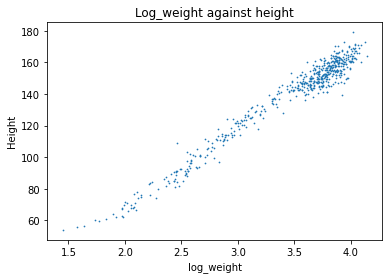

In [96]:
plt.title("Log_weight against height")
plt.scatter(howell1.log_weight, howell1.height, s =0.5)
plt.xlabel("log_weight")
plt.ylabel("Height")
plt.show()

In [99]:
howell1

,height,weight,age,male,log_weight
0,151.765,47.825606,63.0,1,3.867561
1,139.700,36.485807,63.0,0,3.596923
2,136.525,31.864838,65.0,0,3.461503
3,156.845,53.041915,41.0,1,3.971082
4,145.415,41.276872,51.0,0,3.720302
...,...,...,...,...,...
539,145.415,31.127751,17.0,1,3.438100
540,162.560,52.163080,31.0,1,3.954375
541,156.210,54.062496,21.0,0,3.990141
542,71.120,8.051258,0.0,1,2.085828


In [100]:
np.mean(howell1.log_weight)

3.442329848013859

Let's use the following model for the relationship between log weight and height.


$H_i$ ~ $N(\mu_i,\sigma^2)$

$\mu_i = \alpha + \beta(log(x_i) - log(\bar{x}))$

$\alpha$ ~ $N(178,20^2)$

$\beta$ ~ $Log-N(1,10)$

$\sigma$ ~ $Unif(0,50)$

In [102]:
#obtain a linear model with Laplace's approximation
with pm.Model() as m4_1:
    alpha = pm.Normal('alpha', mu=178, sd=20)#prior on alpha
    beta = pm.Lognormal("beta", mu=0,tau=1)#prior on beta
    sigma = pm.Uniform("sigma",0,50)#prior on sigma
    mu = alpha + beta*(howell1.log_weight.values - np.mean(howell1.log_weight.values))
    height = pm.Normal('height', mu=mu, sd=sigma, observed=howell1.height.values)#likelihood of the data
    mean_q = pm.find_MAP()
    print(mean_q)
    Hess = pm.find_hessian(mean_q, vars=[alpha, beta,sigma])#find the hessian matrix

logp = -1,718.1, ||grad|| = 859.12: 100%|██████████| 47/47 [00:02<00:00, 15.87it/s]     


{'alpha': array(138.26840263), 'beta_log__': array(3.85166003), 'sigma_interval__': array(-2.16764365), 'beta': array(47.07113773), 'sigma': array(5.13469817)}


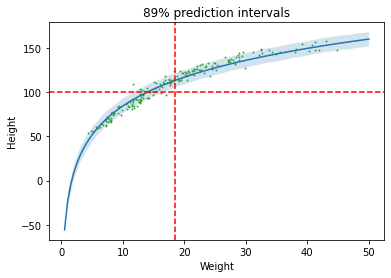

In [128]:
var_cov = np.linalg.inv(Hess)
means = np.fromiter(mean_q.values(), dtype=float)[[0,3,4]]
#resample for posterior for 10,000 sample
post_samples = np.random.multivariate_normal(means, var_cov,size = 10000)
#compute the hpdi for a range of weight values
cred_intervals = np.array([pm.hpd(post_samples[:,0] + post_samples[:,1]*(np.log(x) - np.mean(howell1.log_weight)), credible_interval =0.89) for x in np.linspace(0,50)])
#define a function to compute mu for all posterior samples at given value of x
def compute_mu(x):
    return post_samples[:,0] + post_samples[:,1]*(x - np.mean(howell1.log_weight)) 
#compute the prediction interval in one line
mu = mean_q["alpha"] + mean_q["beta"]*(np.log(np.linspace(0,50,100))- np.mean(howell1.log_weight) )
pred_intervals = np.array([pm.hpd(np.random.normal(loc = compute_mu(x), scale = post_samples[:,2]),credible_interval = 0.89) for x in np.log(np.linspace(0,50))])
plt.fill_between(np.linspace(0,50), pred_intervals[:,0], pred_intervals[:,1],alpha = 0.2)
plt.fill_between(np.linspace(0,50), cred_intervals[:,0], cred_intervals[:,1],alpha = 0.3)
plt.plot(np.linspace(0,50,100) , mu)
plt.scatter(y_data.weight,y_data.height, s = 0.7)
plt.xlabel("Weight")
plt.ylabel("Height")
plt.title("89% prediction intervals")
plt.axvline(np.mean(y_data.weight), ls="--",c="r", label="Mean weight")
plt.axhline(100, ls="--",c="r", label="Mean weight")
plt.show()

Using a log transform of the data appears to give sensible results for our observations. Obviously, extrapolating this fit too far will give terrible conclusions.

4H4. Plot the prior predictive distribution for the parabolic polynomial regression model in the
chapter. You can modify the code that plots the linear regression prior predictive distribution. Can
you modify the prior distributions of α, β1, and β2 so that the prior predictions stay within the biologically reasonable outcome space? That is to say: Do not try to fit the data by hand. But do try to
keep the curves consistent with what you know about height and weight, before seeing these exact
data.

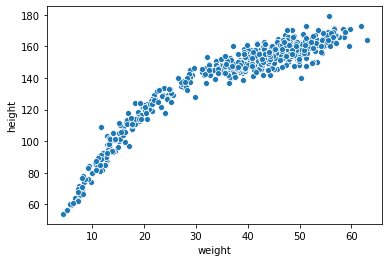

In [191]:
sns.scatterplot(x="weight",y="height",data=howell1)
plt.show()

I implemented the code for this earlier in the notebook but with a modified model. The justifications for the priors are written along side:
    
$H_i$ ~ $N(\mu_i,\sigma^2)$

$\mu_i = \alpha + \beta_1 (x_i - \overline{x}) - \beta_2(x_i - \overline{x})^2 $ #Note that it's -$\beta_2$. Positive prior on $\beta$ ensures the paraboloid curves in the correct direction.

$\alpha$ ~ $N(158,30^2)$ # Reduced mean height at mean weight, as we are looking at a much larger age range now, so we expect younger people to drag the mean height down at any given weight relative to the adult only data set

$\beta_1$ ~ $Lognormal(0,1)$ # Need a linear base line to perturb


The seconds term puts a small deviation from linearity

$\beta_2$ ~ $exp(0.1)$ #This should be positive to ensure concavity, and small to ensure small only small perturbation from linearity in weights

$\sigma$ ~ $Unif(0,50)$

In [345]:
#simulate the prior predictive distribution
alpha = np.random.normal(150,30,size=1000)
beta1 = np.random.lognormal(0,1,1000)
beta2 = np.random.exponential(0.05,size=1000)
sigma = np.random.normal(0,70,1000)
def compute_mu(alpha,beta1,beta2,x):
    return alpha + beta1*(x-np.mean(howell1.weight)) - beta2*(x-np.mean(howell1.weight))**2

In [347]:
pred_intervals = np.array([pm.hpd(compute_mu(alpha,beta1,beta2,x),0.89) for x in np.linspace(0,70)])

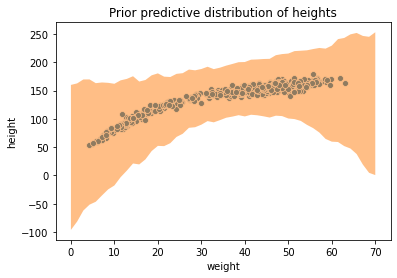

In [349]:
sns.scatterplot(x="weight",y="height",data=howell1)
plt.fill_between(np.linspace(0,70),pred_intervals[:,0],pred_intervals[:,1],alpha = 0.5)
plt.title("Prior predictive distribution of heights")
plt.show()

By using an exponential prior on $\beta_2$ this ensures the parabolic curve must be concave, thus no increasing growth in height with weight is possible and makes perfect sense on physical grounds. However extreme and absurd values are still found near the extremes of the data. One could tighten the parameters to ensure this didn't happen, but as s first approximation based on thinking this isn't too bad.

## Chapter 5 - The many variables & the spurious waffles

simulating a spurious correlation

In [71]:
a = np.random.normal(scale = 10, size=100)
b = np.random.normal(loc=a, scale =5)
c1 = np.random.normal(loc=a, scale =5)
c2 =  np.random.normal(loc=0.5*a+0.5*b, scale =5)

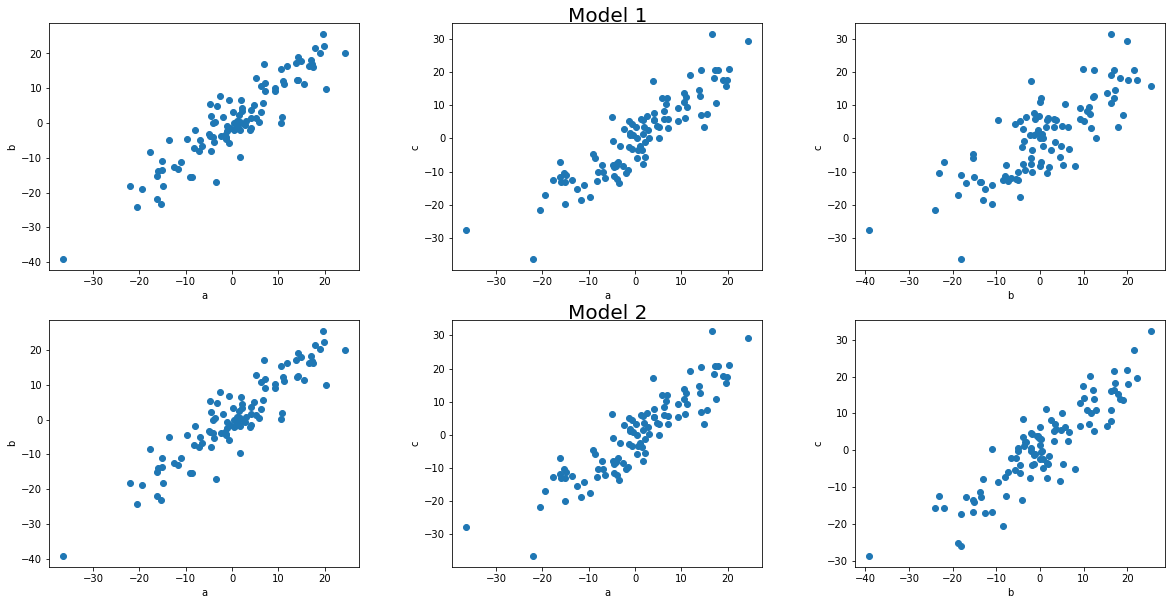

In [88]:
fig,axs = plt.subplots(2,3,figsize=(20,10),)

axs[0,1].set_title("Model 1",y= 0.98, fontsize=20)
axs[1,1].set_title("Model 2",y= 0.98, fontsize=20)
axs[0,0].scatter(a,b)
axs[0,0].set_xlabel("a")
axs[0,0].set_ylabel("b")
axs[0,1].scatter(a,c1)
axs[0,1].set_xlabel("a")
axs[0,1].set_ylabel("c")
axs[0,2].scatter(b,c1)
axs[0,2].set_xlabel("b")
axs[0,2].set_ylabel("c")

axs[1,0].scatter(a,b)
axs[1,0].set_xlabel("a")
axs[1,0].set_ylabel("b")
axs[1,1].scatter(a,c1)
axs[1,1].set_xlabel("a")
axs[1,1].set_ylabel("c")
axs[1,2].scatter(b,c2)
axs[1,2].set_xlabel("b")
axs[1,2].set_ylabel("c")

plt.subplots_adjust(wspace=0.3)

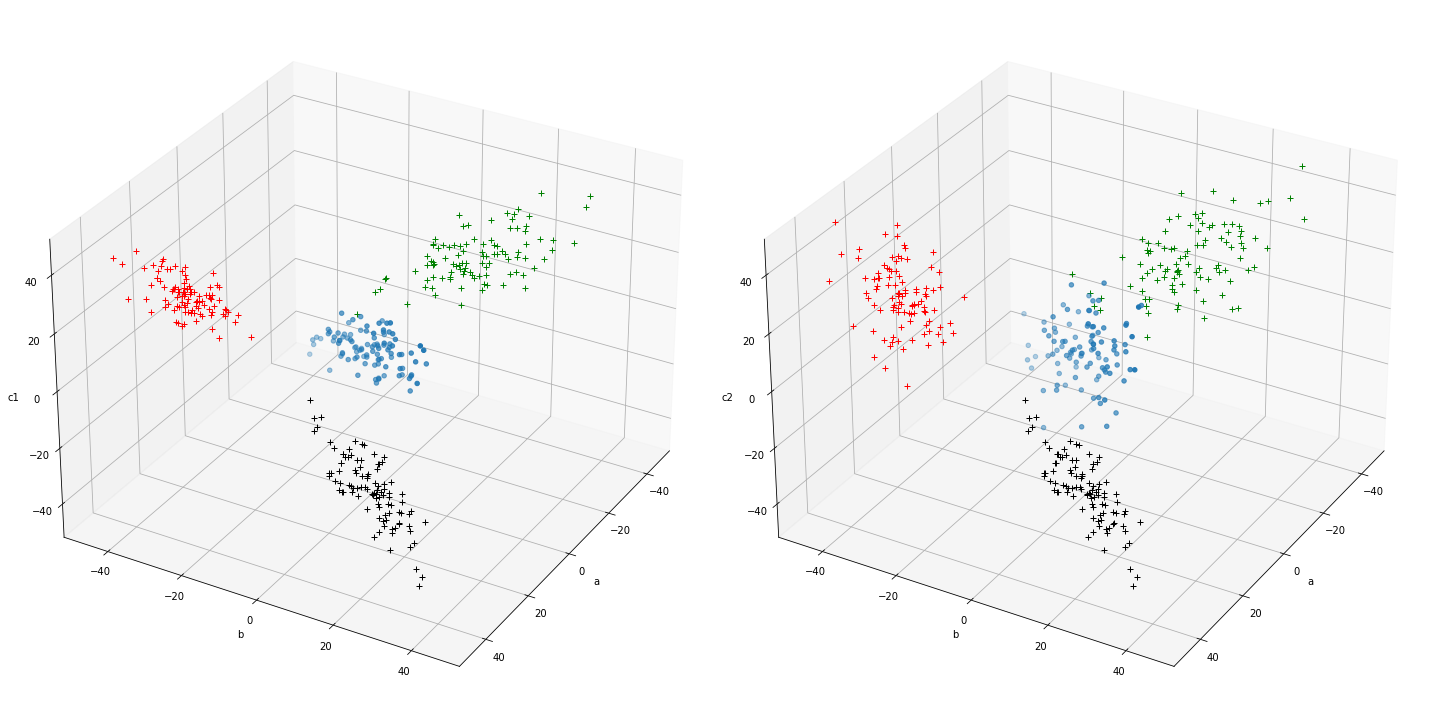

In [481]:
fig = plt.figure(figsize=(20,20))



#===============
#  First subplot
#===============
ax = fig.add_subplot(121, projection='3d')
n = 100

ax.scatter(a,b,c1)

ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('c1')
ax.plot(a,c1, 'r+', zdir='y', zs=-50)
ax.plot(b,c1, 'g+', zdir='x', zs=-50)
ax.plot(a,b, 'k+', zdir='z', zs=-50)
# rotate the axes and update
ax.view_init(30,30)
ax.set_xlim([-50, 50])
ax.set_ylim([-50, 50])
ax.set_zlim([-50, 50])

#===============
#  Second subplot
#===============
ax = fig.add_subplot(122, projection='3d')
n = 100

ax.scatter(a,b,c2)

ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('c2')
ax.plot(a,c2, 'r+', zdir='y', zs=-50)
ax.plot(b,c2, 'g+', zdir='x', zs=-50)
ax.plot(a,b, 'k+', zdir='z', zs=-50)
# rotate the axes and update
ax.view_init(30,30)
ax.set_xlim([-50, 50])
ax.set_ylim([-50, 50])
ax.set_zlim([-50, 50])

plt.tight_layout()

In [3]:
#obtain a linear model with Laplace's approximation
with pm.Model() as m4_1:
    alpha = pm.Normal('alpha', mu=100, sd=10)#prior on alpha
    beta1 = pm.Normal("beta1", mu=0,sd=5)#prior on beta
    beta2 = pm.Normal("beta2", mu=0,sd=5)#prior on beta
    mu = alpha + beta1*a + beta2*b
    height = pm.Normal('height', mu=mu, sd=10, observed=c1)#likelihood of the data
    mean_q = pm.find_MAP()
    print(mean_q)
    Hess = pm.find_hessian(mean_q, vars=[alpha, beta1,beta2])#find the hessian matrix

logp = -392.49, ||grad|| = 0.23909: 100%|██████████| 15/15 [00:00<00:00, 74.75it/s]  


{'alpha': array(1.13533776), 'beta1': array(0.8934901), 'beta2': array(0.16135339)}


In [4]:
var_cov = np.linalg.inv(Hess)

In [5]:
var_cov

array([[ 0.9909489 , -0.00426441,  0.00154623],
       [-0.00426441,  0.04982613, -0.04340007],
       [ 0.00154623, -0.04340007,  0.04749755]])

In [6]:
#obtain a linear model with Laplace's approximation
with pm.Model() as m4_1:
    alpha = pm.Normal('alpha', mu=100, sd=10)#prior on alpha
    beta1 = pm.Normal("beta1", mu=0,sd=10)#prior on beta
    beta2 = pm.Normal("beta2", mu=0,sd=10)#prior on beta
    mu = alpha + beta1*a + beta2*b
    height = pm.Normal('height', mu=mu, sd=10, observed=c2)#likelihood of the data
    mean_q2 = pm.find_MAP()
    print(mean_q2)
    Hess = pm.find_hessian(mean_q, vars=[alpha, beta1,beta2])#find the hessian matrix

logp = -431.04, ||grad|| = 2.2191: 100%|██████████| 15/15 [00:00<00:00, 81.29it/s]  


{'alpha': array(1.45312823), 'beta1': array(0.25658096), 'beta2': array(0.66573618)}


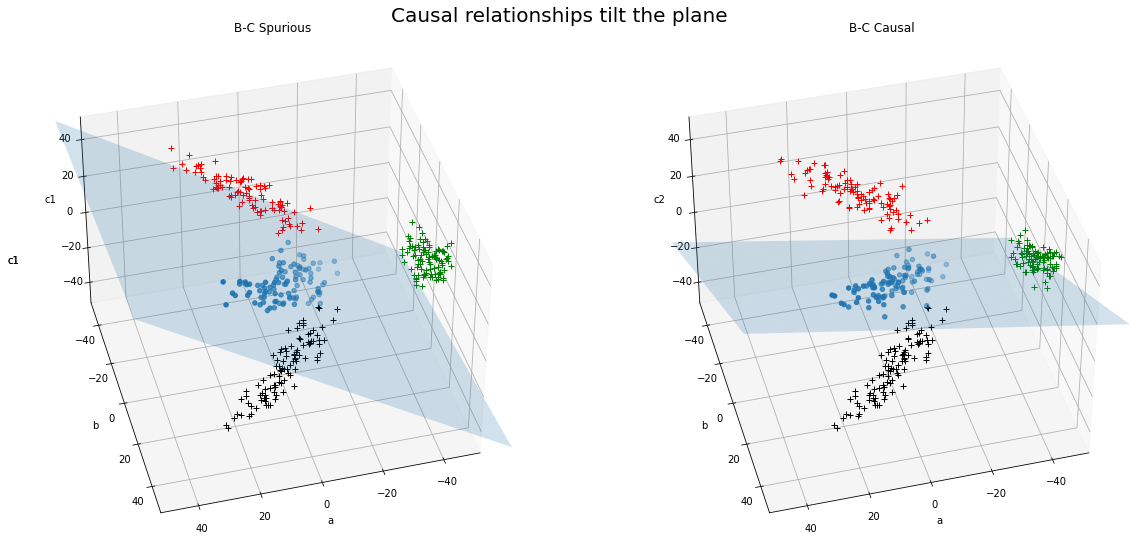

In [56]:
fig = plt.figure(figsize=(20,20))

fig.suptitle("Causal relationships tilt the plane",fontsize=20,y=0.7)
# x = np.linspace(-40,40,1000)
# y = np.linspace(-40,40,1000)
# z = mean_q["alpha"] + x* mean_q["beta1"] + y* mean_q["beta2"]
#===============
#  First subplot
#===============
ax = fig.add_subplot(121, projection='3d')
n = 100
xx, yy = np.meshgrid(range(-40,40), range(-40,40))
z = mean_q["alpha"] + xx* mean_q["beta1"] + yy* mean_q["beta2"]
ax.scatter(a,b,c1)
ax.plot_surface(xx, yy, z, alpha=0.2)

ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('c1')
ax.plot(a,c1, 'r+', zdir='y', zs=-50)
ax.plot(b,c1, 'g+', zdir='x', zs=-50)
ax.plot(a,b, 'k+', zdir='z', zs=-50)
# rotate the axes and update
ax.view_init(30,55)
ax.set_xlim([-50, 50])
ax.set_ylim([-50, 50])
ax.set_zlim([-50, 50])


# x = np.linspace(-40,40,1000)
# y = np.linspace(-40,40,1000)
# z = mean_q["alpha"] + x* mean_q["beta1"] + y* mean_q["beta2"]
#===============
#  First subplot
#===============
ax = fig.add_subplot(121, projection='3d')
n = 100
xx, yy = np.meshgrid(range(-40,40), range(-40,40))
z = mean_q["alpha"] + xx* mean_q["beta1"] + yy* mean_q["beta2"]
ax.scatter(a,b,c1)
ax.plot_surface(xx, yy, z, alpha=0.2)

ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('c1')
ax.plot(a,c1, 'r+', zdir='y', zs=-50)
ax.plot(b,c1, 'g+', zdir='x', zs=-50)
ax.plot(a,b, 'k+', zdir='z', zs=-50)
# rotate the axes and update
ax.view_init(30,55)
ax.set_xlim([-50, 50])
ax.set_ylim([-50, 50])
ax.set_zlim([-50, 50])

ax = fig.add_subplot(121, projection='3d')
n = 100
xx, yy = np.meshgrid(range(-60,60), range(-60,60))
z = mean_q["alpha"] + xx* mean_q["beta1"] + yy* mean_q["beta2"]
ax.scatter(a,b,c1)
ax.plot_surface(xx, yy, z, alpha=0.2)

ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('c1')
ax.plot(a,c1, 'r+', zdir='y', zs=-50)
ax.plot(b,c1, 'g+', zdir='x', zs=-50)
ax.plot(a,b, 'k+', zdir='z', zs=-50)
# rotate the axes and update
ax.view_init(40,75)
ax.set_xlim([-50, 50])
ax.set_ylim([-50, 50])
ax.set_zlim([-50, 50])
ax.set_title("B-C Spurious")

#===============
#  Second subplot
#===============
ax = fig.add_subplot(122, projection='3d')
n = 100
xx, yy = np.meshgrid(range(-60,60), range(-60,60))
z = mean_q2["alpha"] + xx* mean_q2["beta1"] + yy* mean_q2["beta2"]
ax.scatter(a,b,c2)
ax.plot_surface(xx, yy, z, alpha=0.2)

ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('c2')
ax.plot(a,c2, 'r+', zdir='y', zs=-50)
ax.plot(b,c2, 'g+', zdir='x', zs=-50)
ax.plot(a,b, 'k+', zdir='z', zs=-50)
# rotate the axes and update
ax.view_init(40,75)
ax.set_xlim([-50, 50])
ax.set_ylim([-50, 50])
ax.set_zlim([-50, 50])
ax.set_title("B-C Causal")
plt.savefig("Casual relations ships tils the plane")

In [71]:
a = np.random.normal(scale = 10, size=100)
b = np.random.normal(loc=a, scale =5)
c1 = np.random.normal(loc=a, scale =5)
c2 =  np.random.normal(loc=0.5*a+0.5*b, scale =5)

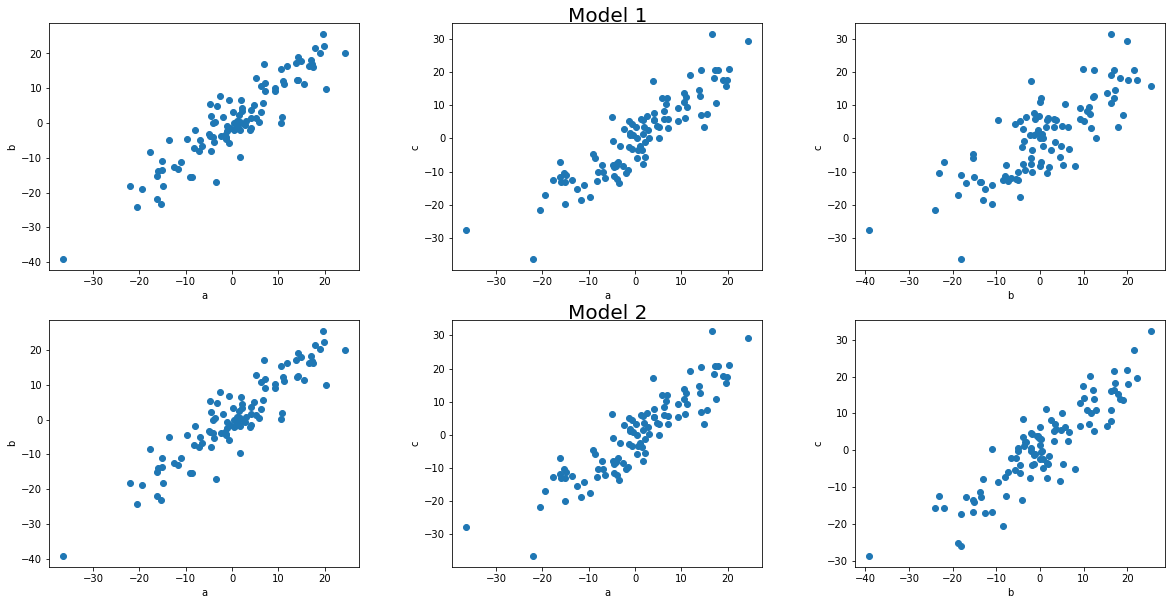

In [88]:
fig,axs = plt.subplots(2,3,figsize=(20,10),)

axs[0,1].set_title("Model 1",y= 0.98, fontsize=20)
axs[1,1].set_title("Model 2",y= 0.98, fontsize=20)
axs[0,0].scatter(a,b)
axs[0,0].set_xlabel("a")
axs[0,0].set_ylabel("b")
axs[0,1].scatter(a,c1)
axs[0,1].set_xlabel("a")
axs[0,1].set_ylabel("c")
axs[0,2].scatter(b,c1)
axs[0,2].set_xlabel("b")
axs[0,2].set_ylabel("c")

axs[1,0].scatter(a,b)
axs[1,0].set_xlabel("a")
axs[1,0].set_ylabel("b")
axs[1,1].scatter(a,c1)
axs[1,1].set_xlabel("a")
axs[1,1].set_ylabel("c")
axs[1,2].scatter(b,c2)
axs[1,2].set_xlabel("b")
axs[1,2].set_ylabel("c")

plt.subplots_adjust(wspace=0.3)

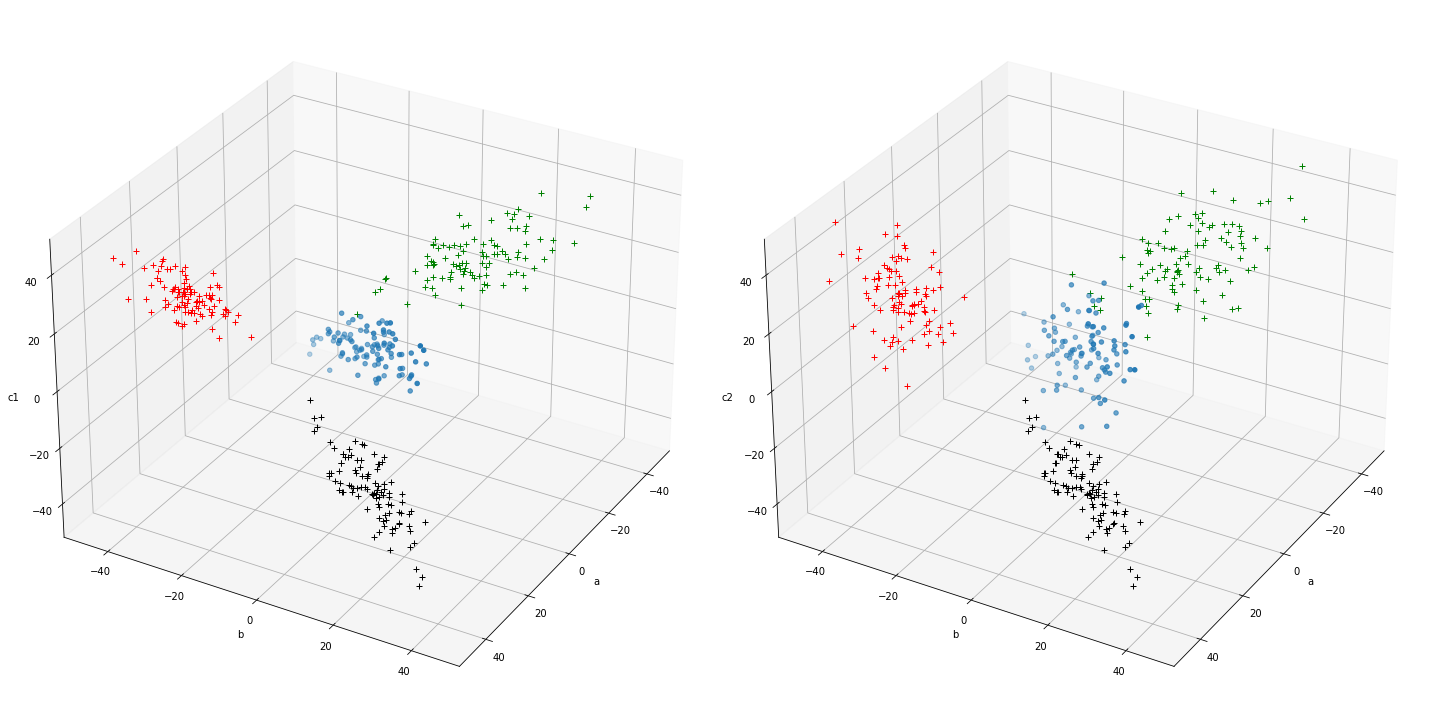

In [481]:
fig = plt.figure(figsize=(20,20))



#===============
#  First subplot
#===============
ax = fig.add_subplot(121, projection='3d')
n = 100

ax.scatter(a,b,c1)

ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('c1')
ax.plot(a,c1, 'r+', zdir='y', zs=-50)
ax.plot(b,c1, 'g+', zdir='x', zs=-50)
ax.plot(a,b, 'k+', zdir='z', zs=-50)
# rotate the axes and update
ax.view_init(30,30)
ax.set_xlim([-50, 50])
ax.set_ylim([-50, 50])
ax.set_zlim([-50, 50])

#===============
#  Second subplot
#===============
ax = fig.add_subplot(122, projection='3d')
n = 100

ax.scatter(a,b,c2)

ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('c2')
ax.plot(a,c2, 'r+', zdir='y', zs=-50)
ax.plot(b,c2, 'g+', zdir='x', zs=-50)
ax.plot(a,b, 'k+', zdir='z', zs=-50)
# rotate the axes and update
ax.view_init(30,30)
ax.set_xlim([-50, 50])
ax.set_ylim([-50, 50])
ax.set_zlim([-50, 50])

plt.tight_layout()

In [3]:
#obtain a linear model with Laplace's approximation
with pm.Model() as m4_1:
    alpha = pm.Normal('alpha', mu=100, sd=10)#prior on alpha
    beta1 = pm.Normal("beta1", mu=0,sd=5)#prior on beta
    beta2 = pm.Normal("beta2", mu=0,sd=5)#prior on beta
    mu = alpha + beta1*a + beta2*b
    height = pm.Normal('height', mu=mu, sd=10, observed=c1)#likelihood of the data
    mean_q = pm.find_MAP()
    print(mean_q)
    Hess = pm.find_hessian(mean_q, vars=[alpha, beta1,beta2])#find the hessian matrix

logp = -392.49, ||grad|| = 0.23909: 100%|██████████| 15/15 [00:00<00:00, 74.75it/s]  


{'alpha': array(1.13533776), 'beta1': array(0.8934901), 'beta2': array(0.16135339)}


In [4]:
var_cov = np.linalg.inv(Hess)

In [5]:
var_cov

array([[ 0.9909489 , -0.00426441,  0.00154623],
       [-0.00426441,  0.04982613, -0.04340007],
       [ 0.00154623, -0.04340007,  0.04749755]])

In [6]:
#obtain a linear model with Laplace's approximation
with pm.Model() as m4_1:
    alpha = pm.Normal('alpha', mu=100, sd=10)#prior on alpha
    beta1 = pm.Normal("beta1", mu=0,sd=10)#prior on beta
    beta2 = pm.Normal("beta2", mu=0,sd=10)#prior on beta
    mu = alpha + beta1*a + beta2*b
    height = pm.Normal('height', mu=mu, sd=10, observed=c2)#likelihood of the data
    mean_q2 = pm.find_MAP()
    print(mean_q2)
    Hess = pm.find_hessian(mean_q, vars=[alpha, beta1,beta2])#find the hessian matrix

logp = -431.04, ||grad|| = 2.2191: 100%|██████████| 15/15 [00:00<00:00, 81.29it/s]  


{'alpha': array(1.45312823), 'beta1': array(0.25658096), 'beta2': array(0.66573618)}


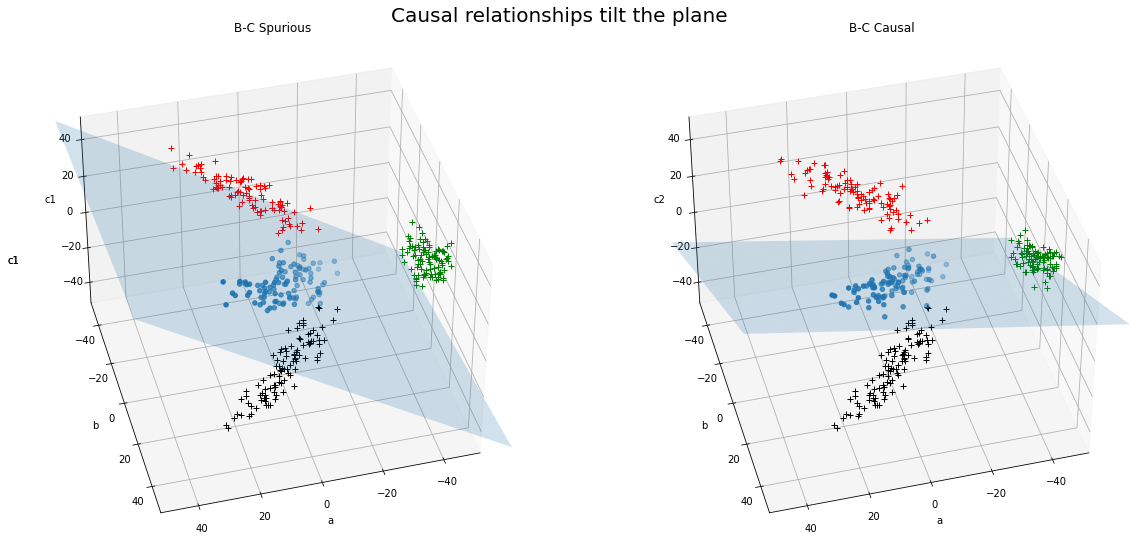

In [56]:
fig = plt.figure(figsize=(20,20))

fig.suptitle("Causal relationships tilt the plane",fontsize=20,y=0.7)
# x = np.linspace(-40,40,1000)
# y = np.linspace(-40,40,1000)
# z = mean_q["alpha"] + x* mean_q["beta1"] + y* mean_q["beta2"]
#===============
#  First subplot
#===============
ax = fig.add_subplot(121, projection='3d')
n = 100
xx, yy = np.meshgrid(range(-40,40), range(-40,40))
z = mean_q["alpha"] + xx* mean_q["beta1"] + yy* mean_q["beta2"]
ax.scatter(a,b,c1)
ax.plot_surface(xx, yy, z, alpha=0.2)

ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('c1')
ax.plot(a,c1, 'r+', zdir='y', zs=-50)
ax.plot(b,c1, 'g+', zdir='x', zs=-50)
ax.plot(a,b, 'k+', zdir='z', zs=-50)
# rotate the axes and update
ax.view_init(30,55)
ax.set_xlim([-50, 50])
ax.set_ylim([-50, 50])
ax.set_zlim([-50, 50])


# x = np.linspace(-40,40,1000)
# y = np.linspace(-40,40,1000)
# z = mean_q["alpha"] + x* mean_q["beta1"] + y* mean_q["beta2"]
#===============
#  First subplot
#===============
ax = fig.add_subplot(121, projection='3d')
n = 100
xx, yy = np.meshgrid(range(-40,40), range(-40,40))
z = mean_q["alpha"] + xx* mean_q["beta1"] + yy* mean_q["beta2"]
ax.scatter(a,b,c1)
ax.plot_surface(xx, yy, z, alpha=0.2)

ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('c1')
ax.plot(a,c1, 'r+', zdir='y', zs=-50)
ax.plot(b,c1, 'g+', zdir='x', zs=-50)
ax.plot(a,b, 'k+', zdir='z', zs=-50)
# rotate the axes and update
ax.view_init(30,55)
ax.set_xlim([-50, 50])
ax.set_ylim([-50, 50])
ax.set_zlim([-50, 50])

ax = fig.add_subplot(121, projection='3d')
n = 100
xx, yy = np.meshgrid(range(-60,60), range(-60,60))
z = mean_q["alpha"] + xx* mean_q["beta1"] + yy* mean_q["beta2"]
ax.scatter(a,b,c1)
ax.plot_surface(xx, yy, z, alpha=0.2)

ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('c1')
ax.plot(a,c1, 'r+', zdir='y', zs=-50)
ax.plot(b,c1, 'g+', zdir='x', zs=-50)
ax.plot(a,b, 'k+', zdir='z', zs=-50)
# rotate the axes and update
ax.view_init(40,75)
ax.set_xlim([-50, 50])
ax.set_ylim([-50, 50])
ax.set_zlim([-50, 50])
ax.set_title("B-C Spurious")

#===============
#  Second subplot
#===============
ax = fig.add_subplot(122, projection='3d')
n = 100
xx, yy = np.meshgrid(range(-60,60), range(-60,60))
z = mean_q2["alpha"] + xx* mean_q2["beta1"] + yy* mean_q2["beta2"]
ax.scatter(a,b,c2)
ax.plot_surface(xx, yy, z, alpha=0.2)

ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('c2')
ax.plot(a,c2, 'r+', zdir='y', zs=-50)
ax.plot(b,c2, 'g+', zdir='x', zs=-50)
ax.plot(a,b, 'k+', zdir='z', zs=-50)
# rotate the axes and update
ax.view_init(40,75)
ax.set_xlim([-50, 50])
ax.set_ylim([-50, 50])
ax.set_zlim([-50, 50])
ax.set_title("B-C Causal")
plt.savefig("Casual relations ships tils the plane")

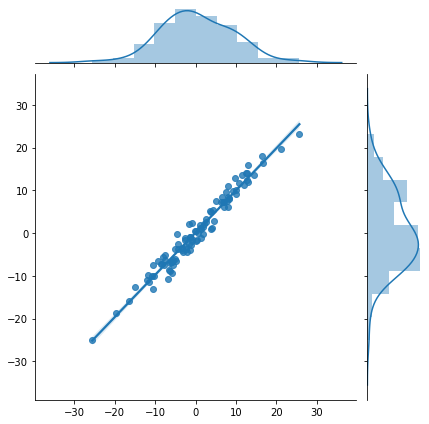

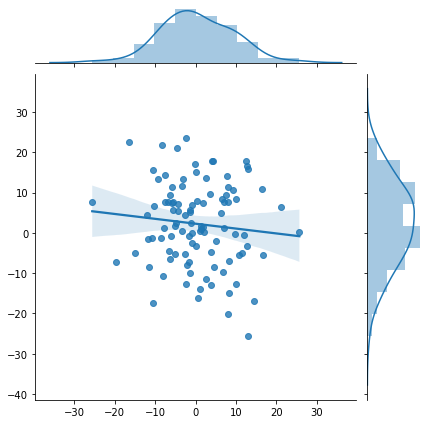

In [46]:
x = np.random.normal(loc = 1, scale = 10, size = 100)
#use x as the mean of y
#this causal model is x->y
y1 = np.random.normal(loc= x, scale = 2)
#get non causal model
y2 = np.random.normal(loc = 1, scale = 10, size = 100)
sns.jointplot(x,y1, kind="reg")
sns.jointplot(x,y2, kind="reg")

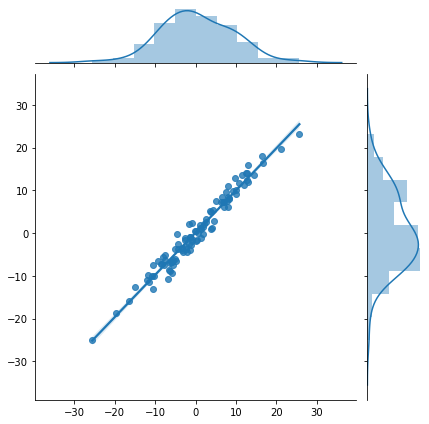

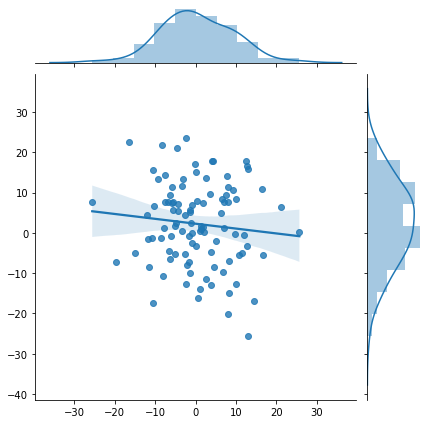

In [46]:
x = np.random.normal(loc = 1, scale = 10, size = 100)
#use x as the mean of y
#this causal model is x->y
y1 = np.random.normal(loc= x, scale = 2)
#get non causal model
y2 = np.random.normal(loc = 1, scale = 10, size = 100)
sns.jointplot(x,y1, kind="reg")
sns.jointplot(x,y2, kind="reg")